In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import math
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import os
import itertools
import numpy as np

In [3]:
class TextValueDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, dial_col):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dial_col = dial_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        text = row[self.dial_col]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

def create_dataloader(df, tokenizer, max_length=256, batch_size=16, dial_col='dialogues'):
    dataset = TextValueDataset(df, tokenizer, max_length, dial_col)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [104]:
epi_df = epi_df[['seeker_post', 'response_post', 'ER_level', 'EX_level', 'IP_level']]
epi_df

,seeker_post,response_post,ER_level,EX_level,IP_level
0,Despair. I wish I had nobody in my life so I f...,I know what you mean. When I was suicidal the ...,0,0,2
1,What are some things I can do to boost my conf...,"I did feel the same way as you, and some days ...",1,0,2
2,You know it’s going to be a good day when you ...,That was me this morning. I felt way alone but...,0,0,2
3,What has helped your depression?. Is anyone cu...,"Definitely not cured, but much better than my ...",0,0,2
4,I am nobody's number one.. I don't mean for th...,I'm not even my fucking number one. I've tried...,0,0,2
...,...,...,...,...,...
2413,Alone. I wanted to help you. I was worried. St...,I hope that letting that out can put you at so...,1,0,0
2414,tired of stay in home pls help. i'm tired of s...,Just do it. Don't think about it. Everything w...,1,0,0
2415,tonight. I give up im done with this bs depres...,"Hey man, wanna talk before you do that? I wann...",1,1,0
2416,Everything that causes my depression is made w...,I know that pain :/ If you ever figure out how...,0,0,1


In [14]:
seeker_list = list(epi_df['seeker_post'])
response_list = list(epi_df['response_post'])
indexes = [(i + 1) % 2 for i in range(len(epi_df['seeker_post']) * 2)]
utterance_list = []
for i in range(len(seeker_list)):
    utterance_list.append(seeker_list[i])
    utterance_list.append(response_list[i])

In [15]:
epi_appdf = {
             'indices':indexes, 
             'utterances':utterance_list
            }
epi_appdf = pd.DataFrame(epi_appdf)
epi_appdf

,indices,utterances
0,1,Despair. I wish I had nobody in my life so I f...
1,0,I know what you mean. When I was suicidal the ...
2,1,What are some things I can do to boost my conf...
3,0,"I did feel the same way as you, and some days ..."
4,1,You know it’s going to be a good day when you ...
...,...,...
4831,0,"Hey man, wanna talk before you do that? I wann..."
4832,1,Everything that causes my depression is made w...
4833,0,I know that pain :/ If you ever figure out how...
4834,1,How toxic is it. Can you die of muriatic acid?


In [32]:
tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-small')
dirname = './models/google-t5/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emp_dataloader = create_dataloader(epi_appdf, tokenizer, dial_col='utterances')

for model_name in os.listdir(dirname):
    # model_name='./models/google-t5/suddenness_google-t5/'
    if '.ipy' in model_name:
        continue
    column = str.join('_', model_name.split('_')[:-1])
    print(column)
    model = AutoModelForSequenceClassification.from_pretrained(os.path.join('./models/google-t5/', model_name))
    model = model.to(device)
    app_store = []
    for batch in tqdm(emp_dataloader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    ).logits
        logits = list(itertools.chain.from_iterable(outputs.cpu().numpy().tolist()))
        logits = [(l*4)+1 for l in logits]
        app_store.extend(logits)
    epi_appdf[column] = app_store
    
    app_store = []
    # Cleanup
    model.to('cpu')
    del model
    torch.cuda.empty_cache()

familiarity


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.38it/s]


goal_support


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.79it/s]


suddenness


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.79it/s]


social_norms


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.88it/s]


not_consider


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.72it/s]


chance_responsblt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.57it/s]


self_responsblt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.62it/s]


other_control


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.56it/s]


pleasantness


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.46it/s]


predict_conseq


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.44it/s]


accept_conseq


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.39it/s]


predict_event


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.55it/s]


urgency


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.40it/s]


other_responsblt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.39it/s]


self_control


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.25it/s]


chance_control


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.39it/s]


standards


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.50it/s]


goal_relevance


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.30it/s]


attention


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.60it/s]


unpleasantness


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:19<00:00, 15.44it/s]


In [93]:
epi_appdf

,indices,utterances,familiarity,goal_support,suddenness,social_norms,not_consider,chance_responsblt,self_responsblt,other_control,...,accept_conseq,predict_event,urgency,other_responsblt,self_control,chance_control,standards,goal_relevance,attention,unpleasantness
0,1,Despair. I wish I had nobody in my life so I f...,3.351814,2.193749,3.203364,2.062130,3.091442,2.778341,3.367256,2.954962,...,3.130492,3.302601,3.319334,2.617717,2.943386,2.240593,3.072788,3.186597,3.718065,3.881119
1,0,I know what you mean. When I was suicidal the ...,2.503653,1.635281,3.350073,2.634157,3.426640,2.097978,2.319624,3.261888,...,2.892467,2.222774,3.740761,3.672634,2.218156,2.041695,3.132232,3.592575,4.086509,4.900979
2,1,What are some things I can do to boost my conf...,2.921936,2.598682,2.779729,1.836923,2.989402,2.030183,3.499891,2.984819,...,3.166666,2.972490,2.900067,2.895505,2.886505,1.997580,2.747466,3.357033,3.568068,3.059080
3,0,"I did feel the same way as you, and some days ...",2.809954,1.892342,3.238573,2.531906,3.015781,1.837294,2.400639,3.661168,...,2.935547,2.198216,3.663852,3.256829,2.273965,1.352845,2.938207,3.447104,3.564017,2.785999
4,1,You know it’s going to be a good day when you ...,3.496422,2.859012,3.482034,1.179535,2.965364,2.347318,3.562233,2.493533,...,3.076473,2.742035,3.223358,1.941309,2.869049,2.086315,2.117633,2.577222,2.793241,2.651115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,0,"Hey man, wanna talk before you do that? I wann...",2.933147,2.051874,3.682078,1.899254,2.620658,1.721211,2.684314,3.500174,...,3.417322,2.274575,3.350300,3.462670,2.547117,1.999842,2.805993,2.843281,3.749991,3.048205
4832,1,Everything that causes my depression is made w...,2.965942,2.366468,3.210835,2.274197,3.613246,2.600783,2.807427,3.316463,...,2.891090,2.867631,3.043940,3.189104,2.653204,3.129673,2.895562,3.095709,3.930757,4.897516
4833,0,I know that pain :/ If you ever figure out how...,3.290495,2.469666,3.586683,1.771471,3.130595,2.790735,2.642565,3.613917,...,3.021257,2.880180,3.318563,3.928237,2.840318,2.239630,2.595869,3.504990,3.760179,3.583518
4834,1,How toxic is it. Can you die of muriatic acid?,2.707320,1.278254,3.540853,2.457822,3.635503,3.356868,1.642007,2.446764,...,2.677320,2.366283,3.136516,2.945530,1.588986,2.795127,3.338613,3.121876,3.423645,4.163934


In [94]:
seeker_df = epi_appdf[epi_appdf['indices'] == 1]
response_df = epi_appdf[epi_appdf['indices'] == 0]
seeker_df.rename(columns={"utterances": "seeker_post"}, inplace=True)
response_df.rename(columns={"utterances": "response_post"}, inplace=True)

/tmp/ipykernel_811014/2116083622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seeker_df.rename(columns={"utterances": "seeker_post"}, inplace=True)
/tmp/ipykernel_811014/2116083622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response_df.rename(columns={"utterances": "response_post"}, inplace=True)


In [95]:
seeker_df.reset_index(inplace=True)
seeker_df

,index,indices,seeker_post,familiarity,goal_support,suddenness,social_norms,not_consider,chance_responsblt,self_responsblt,...,accept_conseq,predict_event,urgency,other_responsblt,self_control,chance_control,standards,goal_relevance,attention,unpleasantness
0,0,1,Despair. I wish I had nobody in my life so I f...,3.351814,2.193749,3.203364,2.062130,3.091442,2.778341,3.367256,...,3.130492,3.302601,3.319334,2.617717,2.943386,2.240593,3.072788,3.186597,3.718065,3.881119
1,2,1,What are some things I can do to boost my conf...,2.921936,2.598682,2.779729,1.836923,2.989402,2.030183,3.499891,...,3.166666,2.972490,2.900067,2.895505,2.886505,1.997580,2.747466,3.357033,3.568068,3.059080
2,4,1,You know it’s going to be a good day when you ...,3.496422,2.859012,3.482034,1.179535,2.965364,2.347318,3.562233,...,3.076473,2.742035,3.223358,1.941309,2.869049,2.086315,2.117633,2.577222,2.793241,2.651115
3,6,1,What has helped your depression?. Is anyone cu...,2.865718,1.593573,3.458332,2.272076,3.348735,2.489299,2.667474,...,2.861408,2.772529,3.330544,3.535624,2.492578,2.211213,3.112519,3.559530,4.023636,3.688542
4,8,1,I am nobody's number one.. I don't mean for th...,2.800605,1.922111,3.189960,2.303423,3.226149,1.973543,3.100405,...,3.138629,2.621984,3.558791,2.723058,2.609703,1.865810,3.120215,3.515798,3.947448,4.050010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,4826,1,Alone. I wanted to help you. I was worried. St...,3.005591,2.611717,3.242361,1.648916,2.736773,2.184581,3.240648,...,3.157529,3.214358,3.349718,3.500716,2.973564,2.053496,2.503384,3.123263,3.580163,3.407831
2414,4828,1,tired of stay in home pls help. i'm tired of s...,3.275604,2.513788,2.934048,2.089287,2.326806,2.240829,2.639860,...,2.760345,2.695832,2.837239,2.846163,2.645120,1.952438,2.592960,2.565430,2.951091,3.092684
2415,4830,1,tonight. I give up im done with this bs depres...,2.933225,1.739421,2.851497,2.033611,2.997561,2.280919,2.794398,...,2.966835,2.752207,3.059442,2.728537,2.525637,2.030216,2.773585,2.598307,3.529470,3.785611
2416,4832,1,Everything that causes my depression is made w...,2.965942,2.366468,3.210835,2.274197,3.613246,2.600783,2.807427,...,2.891090,2.867631,3.043940,3.189104,2.653204,3.129673,2.895562,3.095709,3.930757,4.897516


In [96]:
cols = list(seeker_df.columns)
cols = cols[:3] + [col + '_seeker' for col in cols[3:]]
col_map = {list(seeker_df.columns)[i]:cols[i] for i in range(len(cols))}
seeker_df.rename(columns=col_map)

,index,indices,seeker_post,familiarity_seeker,goal_support_seeker,suddenness_seeker,social_norms_seeker,not_consider_seeker,chance_responsblt_seeker,self_responsblt_seeker,...,accept_conseq_seeker,predict_event_seeker,urgency_seeker,other_responsblt_seeker,self_control_seeker,chance_control_seeker,standards_seeker,goal_relevance_seeker,attention_seeker,unpleasantness_seeker
0,0,1,Despair. I wish I had nobody in my life so I f...,3.351814,2.193749,3.203364,2.062130,3.091442,2.778341,3.367256,...,3.130492,3.302601,3.319334,2.617717,2.943386,2.240593,3.072788,3.186597,3.718065,3.881119
1,2,1,What are some things I can do to boost my conf...,2.921936,2.598682,2.779729,1.836923,2.989402,2.030183,3.499891,...,3.166666,2.972490,2.900067,2.895505,2.886505,1.997580,2.747466,3.357033,3.568068,3.059080
2,4,1,You know it’s going to be a good day when you ...,3.496422,2.859012,3.482034,1.179535,2.965364,2.347318,3.562233,...,3.076473,2.742035,3.223358,1.941309,2.869049,2.086315,2.117633,2.577222,2.793241,2.651115
3,6,1,What has helped your depression?. Is anyone cu...,2.865718,1.593573,3.458332,2.272076,3.348735,2.489299,2.667474,...,2.861408,2.772529,3.330544,3.535624,2.492578,2.211213,3.112519,3.559530,4.023636,3.688542
4,8,1,I am nobody's number one.. I don't mean for th...,2.800605,1.922111,3.189960,2.303423,3.226149,1.973543,3.100405,...,3.138629,2.621984,3.558791,2.723058,2.609703,1.865810,3.120215,3.515798,3.947448,4.050010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,4826,1,Alone. I wanted to help you. I was worried. St...,3.005591,2.611717,3.242361,1.648916,2.736773,2.184581,3.240648,...,3.157529,3.214358,3.349718,3.500716,2.973564,2.053496,2.503384,3.123263,3.580163,3.407831
2414,4828,1,tired of stay in home pls help. i'm tired of s...,3.275604,2.513788,2.934048,2.089287,2.326806,2.240829,2.639860,...,2.760345,2.695832,2.837239,2.846163,2.645120,1.952438,2.592960,2.565430,2.951091,3.092684
2415,4830,1,tonight. I give up im done with this bs depres...,2.933225,1.739421,2.851497,2.033611,2.997561,2.280919,2.794398,...,2.966835,2.752207,3.059442,2.728537,2.525637,2.030216,2.773585,2.598307,3.529470,3.785611
2416,4832,1,Everything that causes my depression is made w...,2.965942,2.366468,3.210835,2.274197,3.613246,2.600783,2.807427,...,2.891090,2.867631,3.043940,3.189104,2.653204,3.129673,2.895562,3.095709,3.930757,4.897516


In [99]:
seeker_df = seeker_df.rename(columns=col_map)
seeker_df

,index,indices,seeker_post,familiarity_seeker,goal_support_seeker,suddenness_seeker,social_norms_seeker,not_consider_seeker,chance_responsblt_seeker,self_responsblt_seeker,...,accept_conseq_seeker,predict_event_seeker,urgency_seeker,other_responsblt_seeker,self_control_seeker,chance_control_seeker,standards_seeker,goal_relevance_seeker,attention_seeker,unpleasantness_seeker
0,0,1,Despair. I wish I had nobody in my life so I f...,3.351814,2.193749,3.203364,2.062130,3.091442,2.778341,3.367256,...,3.130492,3.302601,3.319334,2.617717,2.943386,2.240593,3.072788,3.186597,3.718065,3.881119
1,2,1,What are some things I can do to boost my conf...,2.921936,2.598682,2.779729,1.836923,2.989402,2.030183,3.499891,...,3.166666,2.972490,2.900067,2.895505,2.886505,1.997580,2.747466,3.357033,3.568068,3.059080
2,4,1,You know it’s going to be a good day when you ...,3.496422,2.859012,3.482034,1.179535,2.965364,2.347318,3.562233,...,3.076473,2.742035,3.223358,1.941309,2.869049,2.086315,2.117633,2.577222,2.793241,2.651115
3,6,1,What has helped your depression?. Is anyone cu...,2.865718,1.593573,3.458332,2.272076,3.348735,2.489299,2.667474,...,2.861408,2.772529,3.330544,3.535624,2.492578,2.211213,3.112519,3.559530,4.023636,3.688542
4,8,1,I am nobody's number one.. I don't mean for th...,2.800605,1.922111,3.189960,2.303423,3.226149,1.973543,3.100405,...,3.138629,2.621984,3.558791,2.723058,2.609703,1.865810,3.120215,3.515798,3.947448,4.050010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,4826,1,Alone. I wanted to help you. I was worried. St...,3.005591,2.611717,3.242361,1.648916,2.736773,2.184581,3.240648,...,3.157529,3.214358,3.349718,3.500716,2.973564,2.053496,2.503384,3.123263,3.580163,3.407831
2414,4828,1,tired of stay in home pls help. i'm tired of s...,3.275604,2.513788,2.934048,2.089287,2.326806,2.240829,2.639860,...,2.760345,2.695832,2.837239,2.846163,2.645120,1.952438,2.592960,2.565430,2.951091,3.092684
2415,4830,1,tonight. I give up im done with this bs depres...,2.933225,1.739421,2.851497,2.033611,2.997561,2.280919,2.794398,...,2.966835,2.752207,3.059442,2.728537,2.525637,2.030216,2.773585,2.598307,3.529470,3.785611
2416,4832,1,Everything that causes my depression is made w...,2.965942,2.366468,3.210835,2.274197,3.613246,2.600783,2.807427,...,2.891090,2.867631,3.043940,3.189104,2.653204,3.129673,2.895562,3.095709,3.930757,4.897516


In [97]:
response_df.reset_index(inplace=True)
response_df

,index,indices,response_post,familiarity,goal_support,suddenness,social_norms,not_consider,chance_responsblt,self_responsblt,...,accept_conseq,predict_event,urgency,other_responsblt,self_control,chance_control,standards,goal_relevance,attention,unpleasantness
0,1,0,I know what you mean. When I was suicidal the ...,2.503653,1.635281,3.350073,2.634157,3.426640,2.097978,2.319624,...,2.892467,2.222774,3.740761,3.672634,2.218156,2.041695,3.132232,3.592575,4.086509,4.900979
1,3,0,"I did feel the same way as you, and some days ...",2.809954,1.892342,3.238573,2.531906,3.015781,1.837294,2.400639,...,2.935547,2.198216,3.663852,3.256829,2.273965,1.352845,2.938207,3.447104,3.564017,2.785999
2,5,0,That was me this morning. I felt way alone but...,3.350965,2.810567,3.047751,0.977313,2.755587,2.623139,3.555546,...,3.230122,3.447823,3.241448,2.299032,3.402097,2.487181,1.862707,3.388325,3.647067,2.696160
3,7,0,"Definitely not cured, but much better than my ...",3.398314,2.647128,2.675578,1.802343,2.439828,1.851970,3.327080,...,3.207508,2.951226,2.975424,3.363970,2.807823,1.882721,2.075083,2.829682,3.582061,2.992412
4,9,0,I'm not even my fucking number one. I've tried...,2.900981,1.810436,3.370969,2.186914,3.496379,2.347270,2.960131,...,2.794384,3.091553,3.341902,2.437901,2.571459,2.159324,2.696006,2.909748,3.676506,4.431221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,4827,0,I hope that letting that out can put you at so...,3.521825,3.073642,2.595794,1.858362,2.250100,2.179897,3.420367,...,3.202030,3.443150,2.967595,3.775928,3.346219,1.807643,2.076933,3.251421,3.728053,2.454182
2414,4829,0,Just do it. Don't think about it. Everything w...,2.957238,1.876960,2.953448,2.258612,2.706986,1.959957,2.828154,...,2.704716,2.210708,3.205322,3.189634,2.307032,1.734367,2.715364,2.800567,3.123860,3.527240
2415,4831,0,"Hey man, wanna talk before you do that? I wann...",2.933147,2.051874,3.682078,1.899254,2.620658,1.721211,2.684314,...,3.417322,2.274575,3.350300,3.462670,2.547117,1.999842,2.805993,2.843281,3.749991,3.048205
2416,4833,0,I know that pain :/ If you ever figure out how...,3.290495,2.469666,3.586683,1.771471,3.130595,2.790735,2.642565,...,3.021257,2.880180,3.318563,3.928237,2.840318,2.239630,2.595869,3.504990,3.760179,3.583518


In [100]:
cols = list(response_df.columns)
cols = cols[:3] + [col + '_response' for col in cols[3:]]
col_map = {list(response_df.columns)[i]:cols[i] for i in range(len(cols))}
response_df = response_df.rename(columns=col_map)
response_df

,index,indices,response_post,familiarity_response,goal_support_response,suddenness_response,social_norms_response,not_consider_response,chance_responsblt_response,self_responsblt_response,...,accept_conseq_response,predict_event_response,urgency_response,other_responsblt_response,self_control_response,chance_control_response,standards_response,goal_relevance_response,attention_response,unpleasantness_response
0,1,0,I know what you mean. When I was suicidal the ...,2.503653,1.635281,3.350073,2.634157,3.426640,2.097978,2.319624,...,2.892467,2.222774,3.740761,3.672634,2.218156,2.041695,3.132232,3.592575,4.086509,4.900979
1,3,0,"I did feel the same way as you, and some days ...",2.809954,1.892342,3.238573,2.531906,3.015781,1.837294,2.400639,...,2.935547,2.198216,3.663852,3.256829,2.273965,1.352845,2.938207,3.447104,3.564017,2.785999
2,5,0,That was me this morning. I felt way alone but...,3.350965,2.810567,3.047751,0.977313,2.755587,2.623139,3.555546,...,3.230122,3.447823,3.241448,2.299032,3.402097,2.487181,1.862707,3.388325,3.647067,2.696160
3,7,0,"Definitely not cured, but much better than my ...",3.398314,2.647128,2.675578,1.802343,2.439828,1.851970,3.327080,...,3.207508,2.951226,2.975424,3.363970,2.807823,1.882721,2.075083,2.829682,3.582061,2.992412
4,9,0,I'm not even my fucking number one. I've tried...,2.900981,1.810436,3.370969,2.186914,3.496379,2.347270,2.960131,...,2.794384,3.091553,3.341902,2.437901,2.571459,2.159324,2.696006,2.909748,3.676506,4.431221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,4827,0,I hope that letting that out can put you at so...,3.521825,3.073642,2.595794,1.858362,2.250100,2.179897,3.420367,...,3.202030,3.443150,2.967595,3.775928,3.346219,1.807643,2.076933,3.251421,3.728053,2.454182
2414,4829,0,Just do it. Don't think about it. Everything w...,2.957238,1.876960,2.953448,2.258612,2.706986,1.959957,2.828154,...,2.704716,2.210708,3.205322,3.189634,2.307032,1.734367,2.715364,2.800567,3.123860,3.527240
2415,4831,0,"Hey man, wanna talk before you do that? I wann...",2.933147,2.051874,3.682078,1.899254,2.620658,1.721211,2.684314,...,3.417322,2.274575,3.350300,3.462670,2.547117,1.999842,2.805993,2.843281,3.749991,3.048205
2416,4833,0,I know that pain :/ If you ever figure out how...,3.290495,2.469666,3.586683,1.771471,3.130595,2.790735,2.642565,...,3.021257,2.880180,3.318563,3.928237,2.840318,2.239630,2.595869,3.504990,3.760179,3.583518


In [105]:
epi_df = pd.concat([epi_df, seeker_df], axis=1)
epi_df = pd.concat([epi_df, response_df], axis=1)

In [123]:
epi_df

,seeker_post,response_post,ER_level,EX_level,IP_level,index,indices,seeker_post,familiarity_seeker,goal_support_seeker,...,accept_conseq_response,predict_event_response,urgency_response,other_responsblt_response,self_control_response,chance_control_response,standards_response,goal_relevance_response,attention_response,unpleasantness_response
0,Despair. I wish I had nobody in my life so I f...,I know what you mean. When I was suicidal the ...,0,0,2,0,1,Despair. I wish I had nobody in my life so I f...,3.351814,2.193749,...,2.892467,2.222774,3.740761,3.672634,2.218156,2.041695,3.132232,3.592575,4.086509,4.900979
1,What are some things I can do to boost my conf...,"I did feel the same way as you, and some days ...",1,0,2,2,1,What are some things I can do to boost my conf...,2.921936,2.598682,...,2.935547,2.198216,3.663852,3.256829,2.273965,1.352845,2.938207,3.447104,3.564017,2.785999
2,You know it’s going to be a good day when you ...,That was me this morning. I felt way alone but...,0,0,2,4,1,You know it’s going to be a good day when you ...,3.496422,2.859012,...,3.230122,3.447823,3.241448,2.299032,3.402097,2.487181,1.862707,3.388325,3.647067,2.696160
3,What has helped your depression?. Is anyone cu...,"Definitely not cured, but much better than my ...",0,0,2,6,1,What has helped your depression?. Is anyone cu...,2.865718,1.593573,...,3.207508,2.951226,2.975424,3.363970,2.807823,1.882721,2.075083,2.829682,3.582061,2.992412
4,I am nobody's number one.. I don't mean for th...,I'm not even my fucking number one. I've tried...,0,0,2,8,1,I am nobody's number one.. I don't mean for th...,2.800605,1.922111,...,2.794384,3.091553,3.341902,2.437901,2.571459,2.159324,2.696006,2.909748,3.676506,4.431221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,Alone. I wanted to help you. I was worried. St...,I hope that letting that out can put you at so...,1,0,0,4826,1,Alone. I wanted to help you. I was worried. St...,3.005591,2.611717,...,3.202030,3.443150,2.967595,3.775928,3.346219,1.807643,2.076933,3.251421,3.728053,2.454182
2414,tired of stay in home pls help. i'm tired of s...,Just do it. Don't think about it. Everything w...,1,0,0,4828,1,tired of stay in home pls help. i'm tired of s...,3.275604,2.513788,...,2.704716,2.210708,3.205322,3.189634,2.307032,1.734367,2.715364,2.800567,3.123860,3.527240
2415,tonight. I give up im done with this bs depres...,"Hey man, wanna talk before you do that? I wann...",1,1,0,4830,1,tonight. I give up im done with this bs depres...,2.933225,1.739421,...,3.417322,2.274575,3.350300,3.462670,2.547117,1.999842,2.805993,2.843281,3.749991,3.048205
2416,Everything that causes my depression is made w...,I know that pain :/ If you ever figure out how...,0,0,1,4832,1,Everything that causes my depression is made w...,2.965942,2.366468,...,3.021257,2.880180,3.318563,3.928237,2.840318,2.239630,2.595869,3.504990,3.760179,3.583518


In [107]:
epi_df.to_csv('./appraised_epitome.csv')

In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

col_list = []
# col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
for col in epi_df.columns:
    if '_seeker' in col:
    # '_level' in col:
        # or '_response' in col 
        col_list.append(col)

seeker_df = epi_df[col_list]
corr_matrix = seeker_df.corr()
print(corr_matrix)

                          familiarity_seeker  goal_support_seeker  \
familiarity_seeker                  1.000000             0.191058   
goal_support_seeker                 0.191058             1.000000   
suddenness_seeker                  -0.219320            -0.202229   
social_norms_seeker                -0.144350            -0.587138   
not_consider_seeker                 0.029968            -0.602155   
chance_responsblt_seeker           -0.051460            -0.140026   
self_responsblt_seeker              0.270300             0.312619   
other_control_seeker               -0.203789             0.020234   
pleasantness_seeker                 0.032806             0.754195   
predict_conseq_seeker               0.316197             0.213451   
accept_conseq_seeker                0.173451             0.377254   
predict_event_seeker                0.414915             0.295834   
urgency_seeker                     -0.307186            -0.177825   
other_responsblt_seeker           

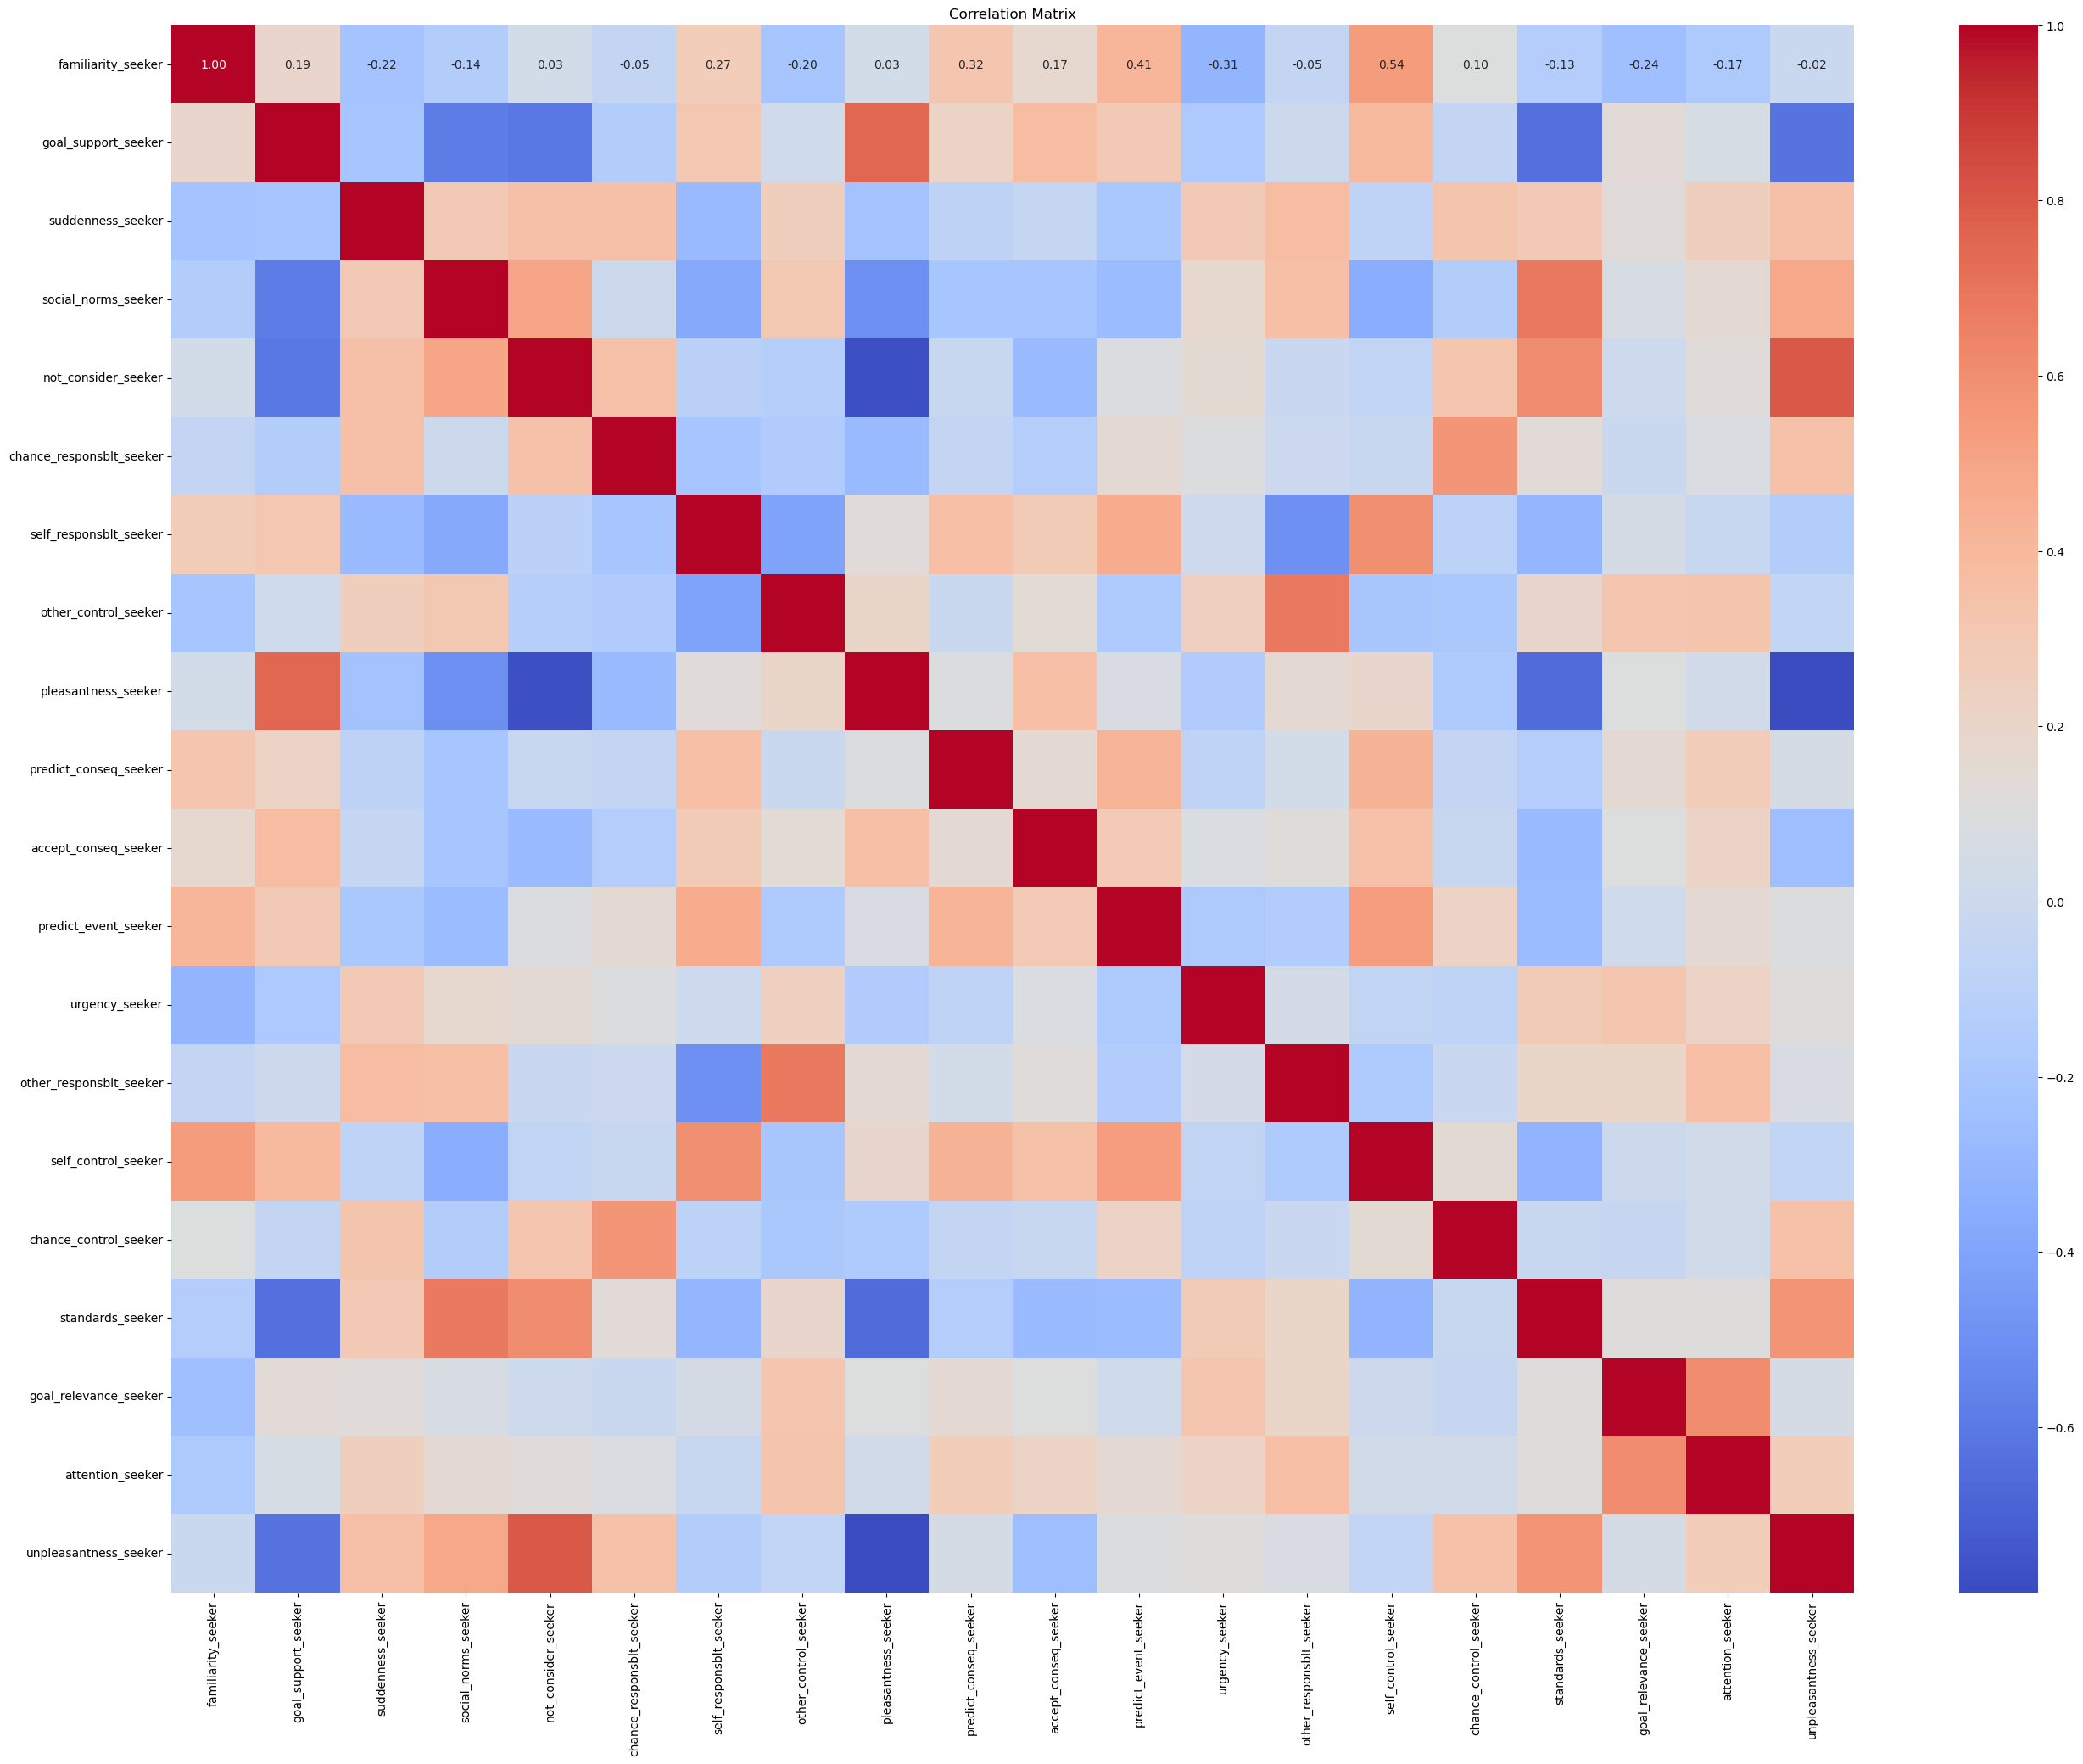

In [144]:
plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [145]:
col_list = []
# col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
for col in epi_df.columns:
    if '_response' in col:
    # or '_level' in col:
        # or '_seeker' in col 
        col_list.append(col)

response_df = epi_df[col_list]
corr_matrix = response_df.corr()
print(corr_matrix)

                            familiarity_response  goal_support_response  \
familiarity_response                    1.000000               0.270314   
goal_support_response                   0.270314               1.000000   
suddenness_response                    -0.275114              -0.326517   
social_norms_response                  -0.294341              -0.677390   
not_consider_response                  -0.162302              -0.714908   
chance_responsblt_response             -0.014171              -0.160211   
self_responsblt_response                0.372539               0.422696   
other_control_response                 -0.167248               0.127381   
pleasantness_response                   0.179837               0.815078   
predict_conseq_response                 0.466090               0.387677   
accept_conseq_response                  0.230214               0.517832   
predict_event_response                  0.533287               0.453807   
urgency_response         

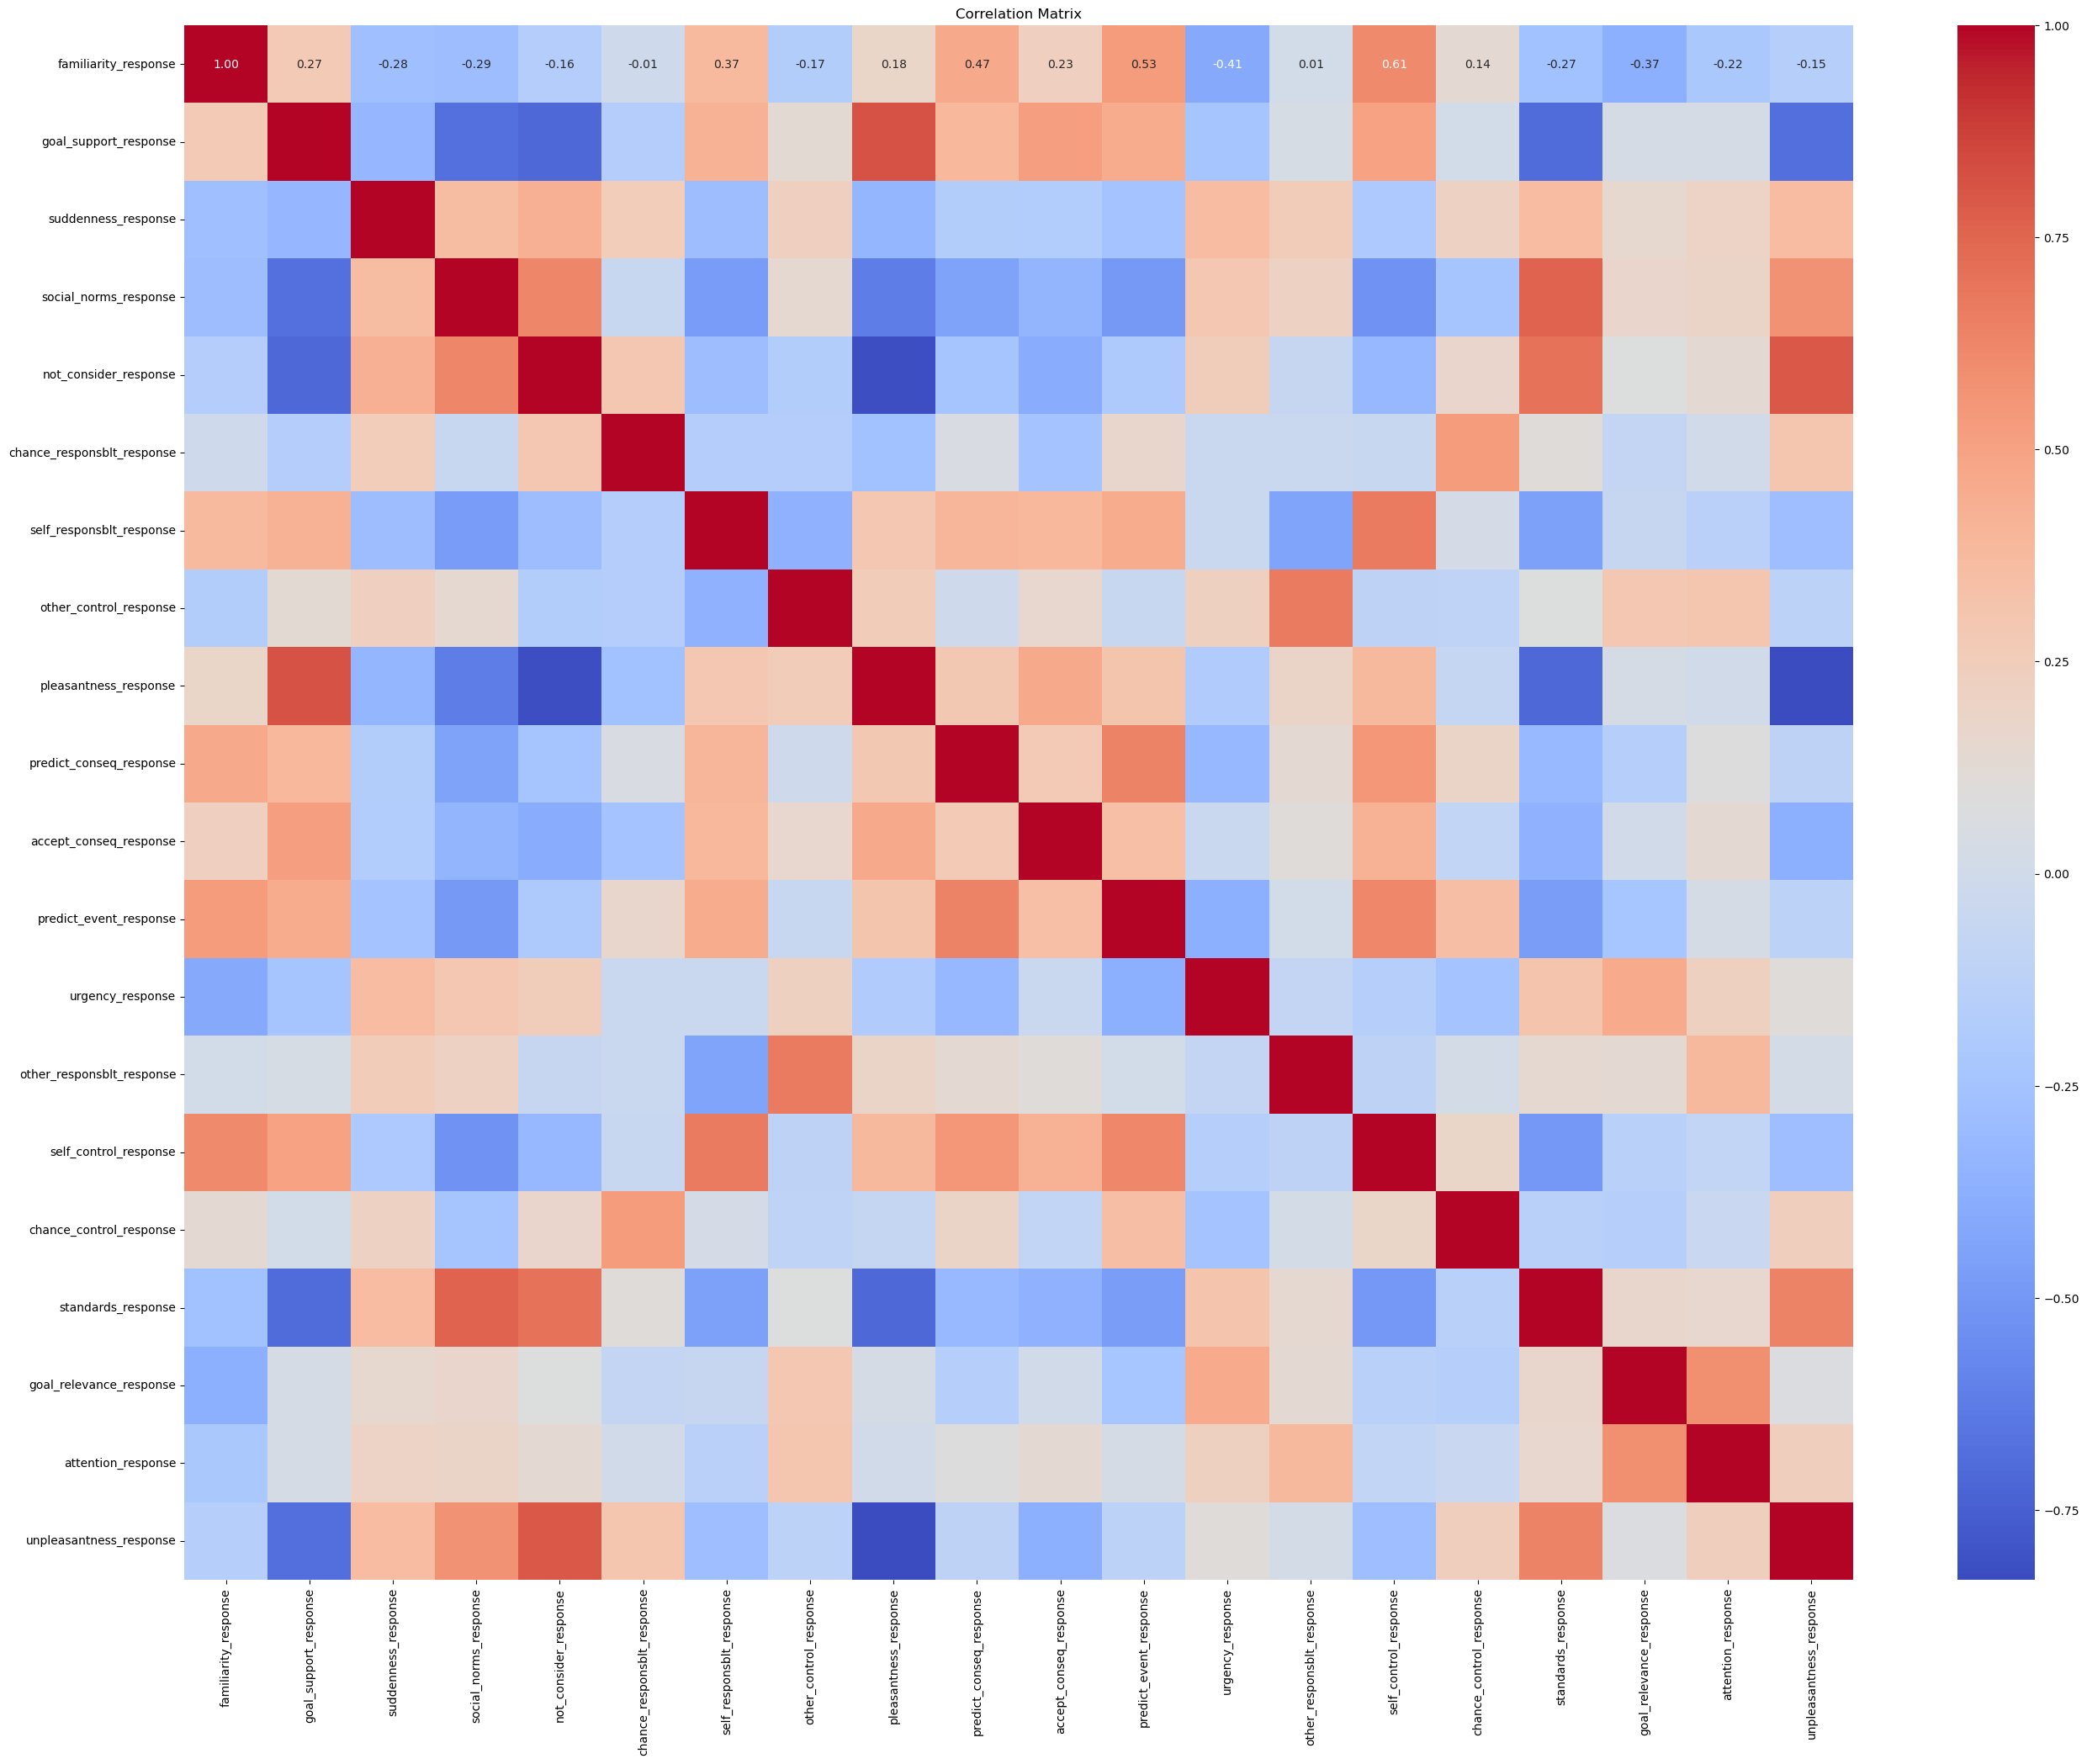

In [146]:
plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [147]:
seeker_df

,familiarity_seeker,goal_support_seeker,suddenness_seeker,social_norms_seeker,not_consider_seeker,chance_responsblt_seeker,self_responsblt_seeker,other_control_seeker,pleasantness_seeker,predict_conseq_seeker,accept_conseq_seeker,predict_event_seeker,urgency_seeker,other_responsblt_seeker,self_control_seeker,chance_control_seeker,standards_seeker,goal_relevance_seeker,attention_seeker,unpleasantness_seeker
0,3.351814,2.193749,3.203364,2.062130,3.091442,2.778341,3.367256,2.954962,1.445992,3.579924,3.130492,3.302601,3.319334,2.617717,2.943386,2.240593,3.072788,3.186597,3.718065,3.881119
1,2.921936,2.598682,2.779729,1.836923,2.989402,2.030183,3.499891,2.984819,2.301920,3.247290,3.166666,2.972490,2.900067,2.895505,2.886505,1.997580,2.747466,3.357033,3.568068,3.059080
2,3.496422,2.859012,3.482034,1.179535,2.965364,2.347318,3.562233,2.493533,2.258167,2.703814,3.076473,2.742035,3.223358,1.941309,2.869049,2.086315,2.117633,2.577222,2.793241,2.651115
3,2.865718,1.593573,3.458332,2.272076,3.348735,2.489299,2.667474,3.364470,1.921838,3.364671,2.861408,2.772529,3.330544,3.535624,2.492578,2.211213,3.112519,3.559530,4.023636,3.688542
4,2.800605,1.922111,3.189960,2.303423,3.226149,1.973543,3.100405,2.968588,1.842183,2.943545,3.138629,2.621984,3.558791,2.723058,2.609703,1.865810,3.120215,3.515798,3.947448,4.050010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,3.005591,2.611717,3.242361,1.648916,2.736773,2.184581,3.240648,3.510664,2.606409,3.246454,3.157529,3.214358,3.349718,3.500716,2.973564,2.053496,2.503384,3.123263,3.580163,3.407831
2414,3.275604,2.513788,2.934048,2.089287,2.326806,2.240829,2.639860,2.695505,2.313758,2.950539,2.760345,2.695832,2.837239,2.846163,2.645120,1.952438,2.592960,2.565430,2.951091,3.092684
2415,2.933225,1.739421,2.851497,2.033611,2.997561,2.280919,2.794398,2.999426,1.553917,2.945475,2.966835,2.752207,3.059442,2.728537,2.525637,2.030216,2.773585,2.598307,3.529470,3.785611
2416,2.965942,2.366468,3.210835,2.274197,3.613246,2.600783,2.807427,3.316463,1.409690,3.122535,2.891090,2.867631,3.043940,3.189104,2.653204,3.129673,2.895562,3.095709,3.930757,4.897516


In [149]:
stats_df = dict()
cols = seeker_df.columns
for ix in range(len(cols)):
    seeker_col = cols[ix]
    response_col = '_'.join(cols[ix].split('_')[:-1]) + '_response'
    stats_df['_'.join(cols[ix].split('_')[:-1]) + '_avg'] = 0.5*seeker_df[seeker_col] + 0.5*response_df[response_col]

stats_df = pd.DataFrame(stats_df)
stats_df

,familiarity_avg,goal_support_avg,suddenness_avg,social_norms_avg,not_consider_avg,chance_responsblt_avg,self_responsblt_avg,other_control_avg,pleasantness_avg,predict_conseq_avg,accept_conseq_avg,predict_event_avg,urgency_avg,other_responsblt_avg,self_control_avg,chance_control_avg,standards_avg,goal_relevance_avg,attention_avg,unpleasantness_avg
0,2.927733,1.914515,3.276719,2.348144,3.259041,2.438160,2.843440,3.108425,1.516020,3.134036,3.011480,2.762687,3.530047,3.145176,2.580771,2.141144,3.102510,3.389586,3.902287,4.391049
1,2.865945,2.245512,3.009151,2.184414,3.002591,1.933738,2.950265,3.322993,2.261779,2.844628,3.051107,2.585353,3.281959,3.076167,2.580235,1.675213,2.842836,3.402069,3.566042,2.922539
2,3.423693,2.834790,3.264893,1.078424,2.860476,2.485228,3.558890,2.462950,2.605466,3.017109,3.153298,3.094929,3.232403,2.120171,3.135573,2.286748,1.990170,2.982773,3.220154,2.673638
3,3.132016,2.120351,3.066955,2.037209,2.894282,2.170635,2.997277,3.198172,2.445499,3.180458,3.034458,2.861878,3.152984,3.449797,2.650201,2.046967,2.593801,3.194606,3.802849,3.340477
4,2.850793,1.866273,3.280465,2.245168,3.361264,2.160406,3.030268,2.875927,1.496845,3.042014,2.966506,2.856768,3.450347,2.580479,2.590581,2.012567,2.908110,3.212773,3.811977,4.240616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,3.263708,2.842679,2.919077,1.753639,2.493437,2.182239,3.330508,3.451771,3.275464,3.299173,3.179780,3.328754,3.158657,3.638322,3.159892,1.930570,2.290159,3.187342,3.654108,2.931006
2414,3.116421,2.195374,2.943748,2.173950,2.516896,2.100393,2.734007,2.939564,1.918526,2.958857,2.732530,2.453270,3.021281,3.017898,2.476076,1.843403,2.654162,2.682998,3.037476,3.309962
2415,2.933186,1.895648,3.266788,1.966433,2.809110,2.001065,2.739356,3.249800,1.865556,2.954058,3.192078,2.513391,3.204871,3.095603,2.536377,2.015029,2.789789,2.720794,3.639731,3.416908
2416,3.128219,2.418067,3.398759,2.022834,3.371921,2.695759,2.724996,3.465190,1.954938,3.095985,2.956174,2.873905,3.181252,3.558670,2.746761,2.684651,2.745716,3.300350,3.845468,4.240517


In [150]:
corr_matrix = stats_df.corr()
print(corr_matrix)

                       familiarity_avg  goal_support_avg  suddenness_avg  \
familiarity_avg               1.000000          0.228403       -0.260294   
goal_support_avg              0.228403          1.000000       -0.305810   
suddenness_avg               -0.260294         -0.305810        1.000000   
social_norms_avg             -0.220833         -0.663789        0.350915   
not_consider_avg             -0.067742         -0.691713        0.399573   
chance_responsblt_avg        -0.030563         -0.173475        0.301761   
self_responsblt_avg           0.363187          0.393307       -0.305190   
other_control_avg            -0.228925          0.048933        0.255141   
pleasantness_avg              0.100761          0.813200       -0.313081   
predict_conseq_avg            0.397327          0.309071       -0.141429   
accept_conseq_avg             0.196051          0.454962       -0.129226   
predict_event_avg             0.497972          0.391211       -0.243462   
urgency_avg 

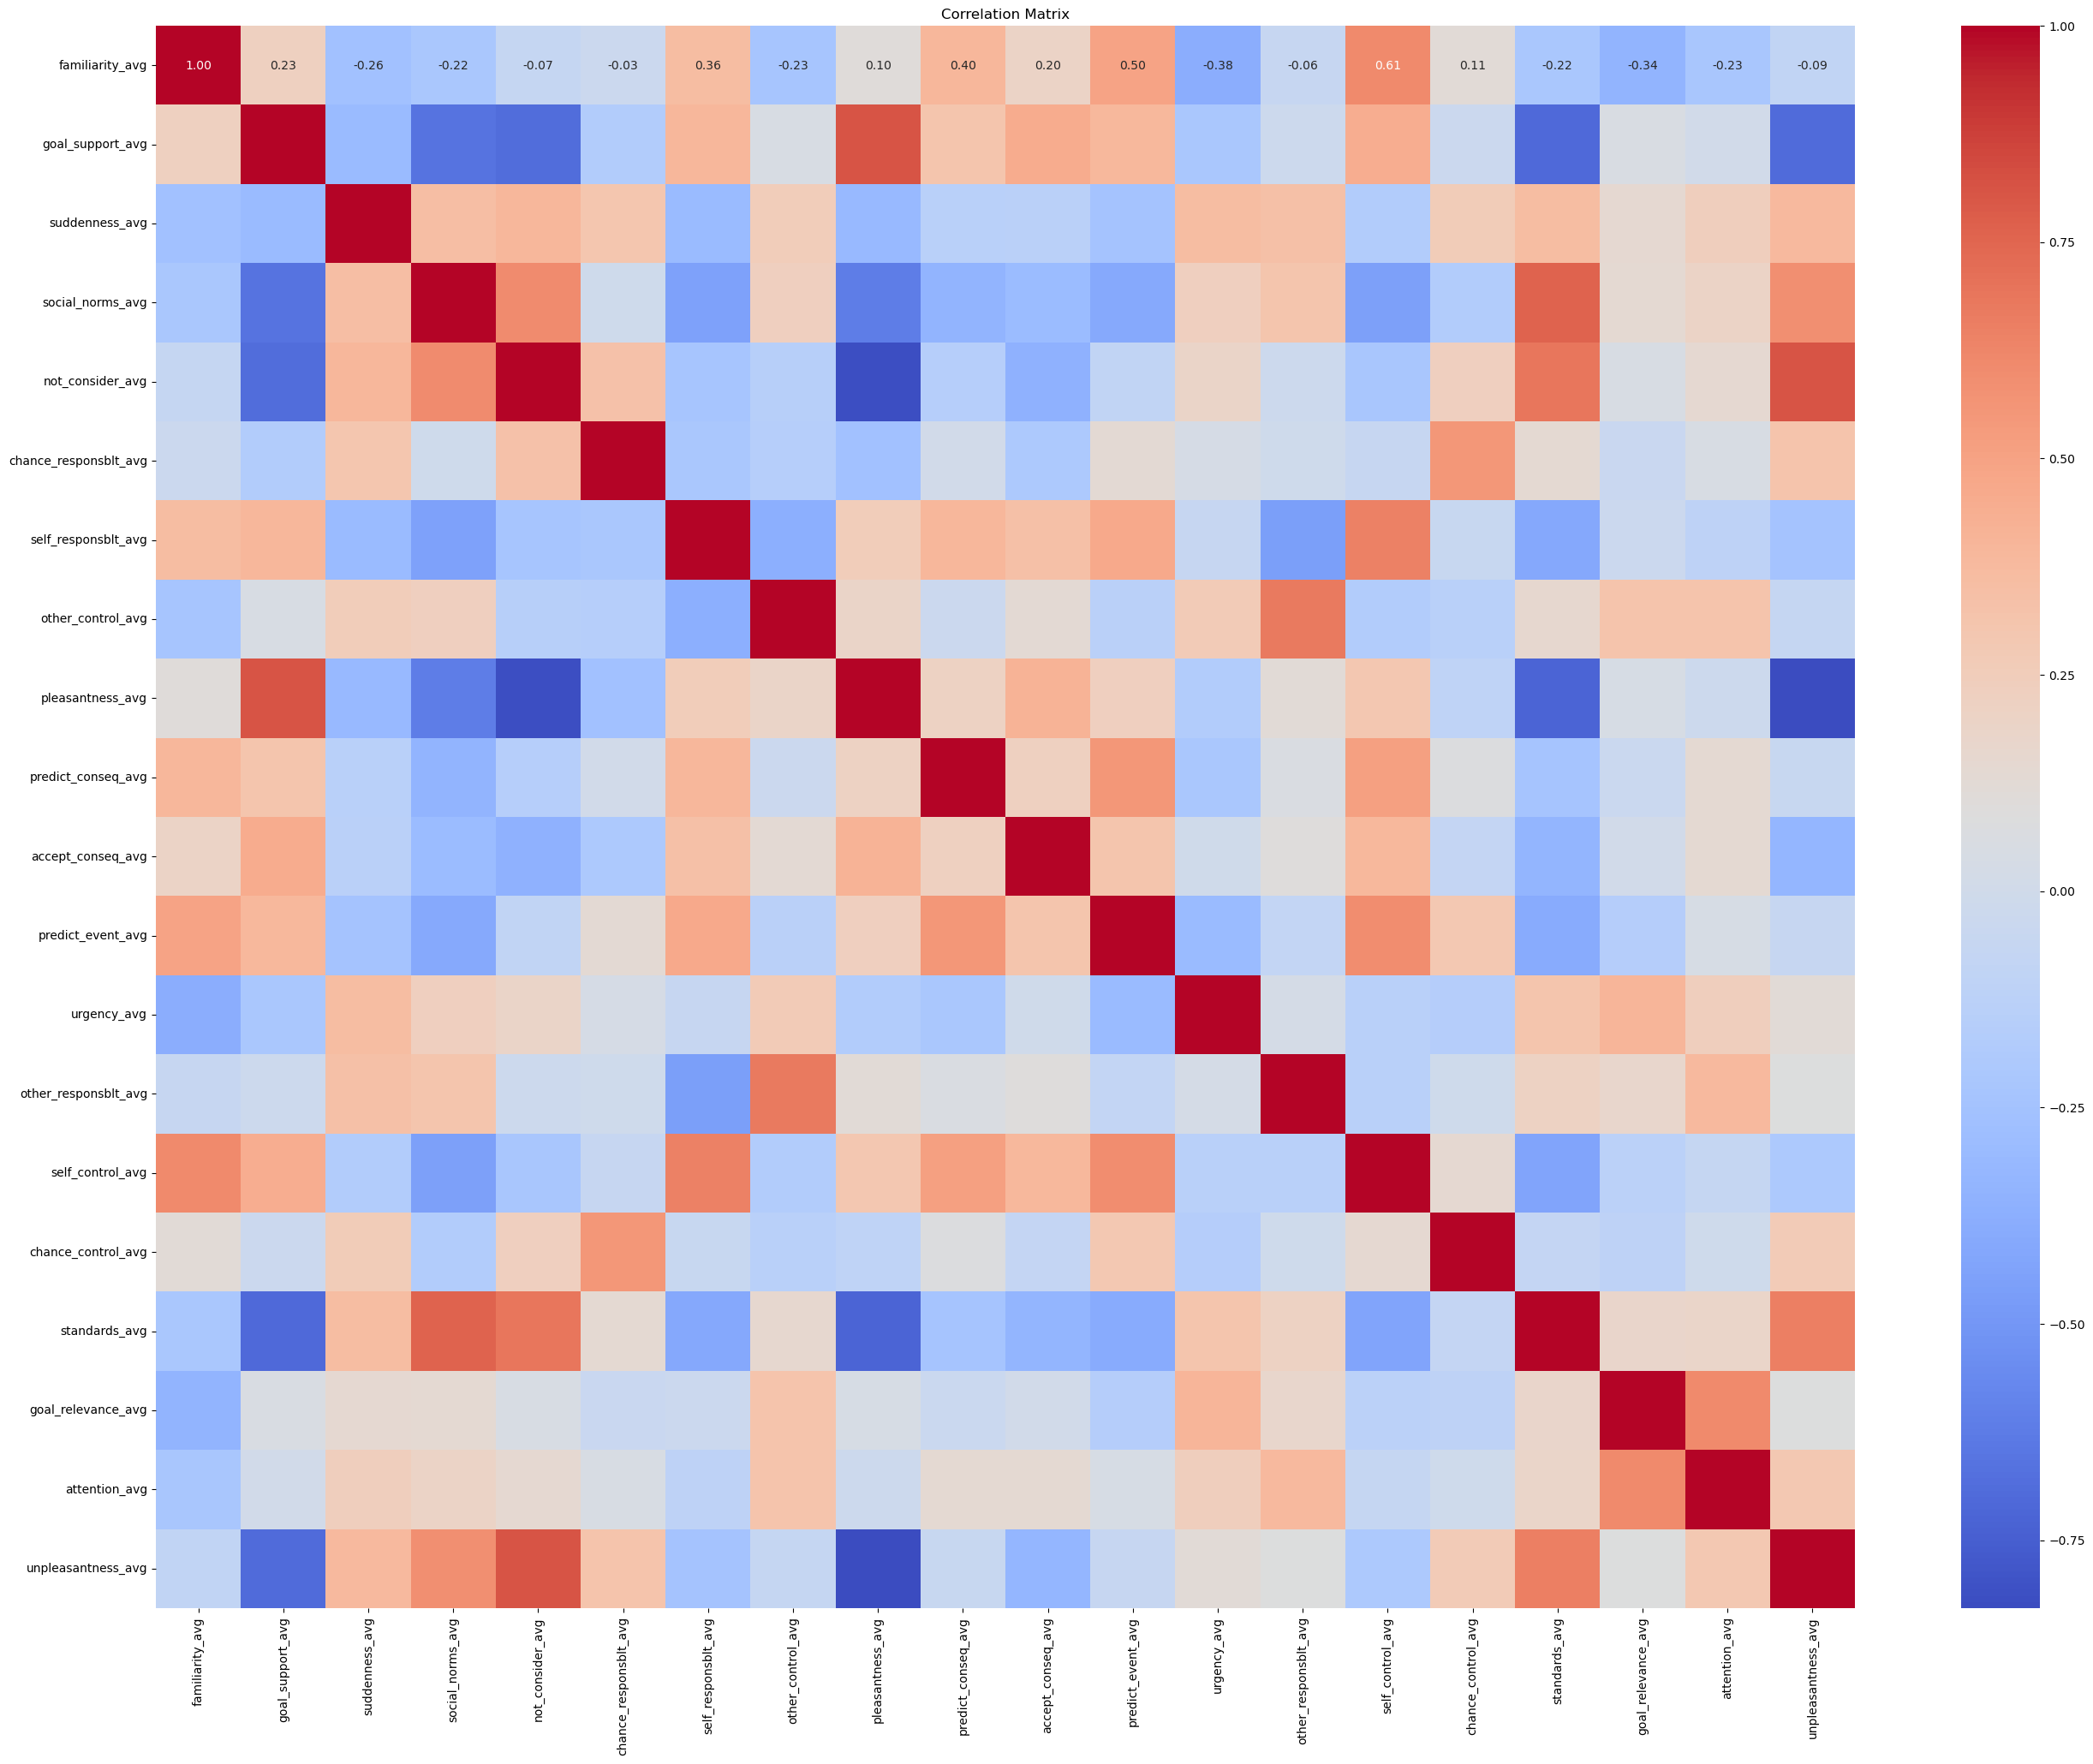

In [151]:
plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [152]:
col_list = []
# col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
for col in epi_df.columns:
    if '_seeker' in col or '_response' in col:
        col_list.append(col)

seeker_df = epi_df[col_list]
corr_matrix = seeker_df.corr()
print(corr_matrix)

                            familiarity_seeker  goal_support_seeker  \
familiarity_seeker                    1.000000             0.191058   
goal_support_seeker                   0.191058             1.000000   
suddenness_seeker                    -0.219320            -0.202229   
social_norms_seeker                  -0.144350            -0.587138   
not_consider_seeker                   0.029968            -0.602155   
chance_responsblt_seeker             -0.051460            -0.140026   
self_responsblt_seeker                0.270300             0.312619   
other_control_seeker                 -0.203789             0.020234   
pleasantness_seeker                   0.032806             0.754195   
predict_conseq_seeker                 0.316197             0.213451   
accept_conseq_seeker                  0.173451             0.377254   
predict_event_seeker                  0.414915             0.295834   
urgency_seeker                       -0.307186            -0.177825   
other_

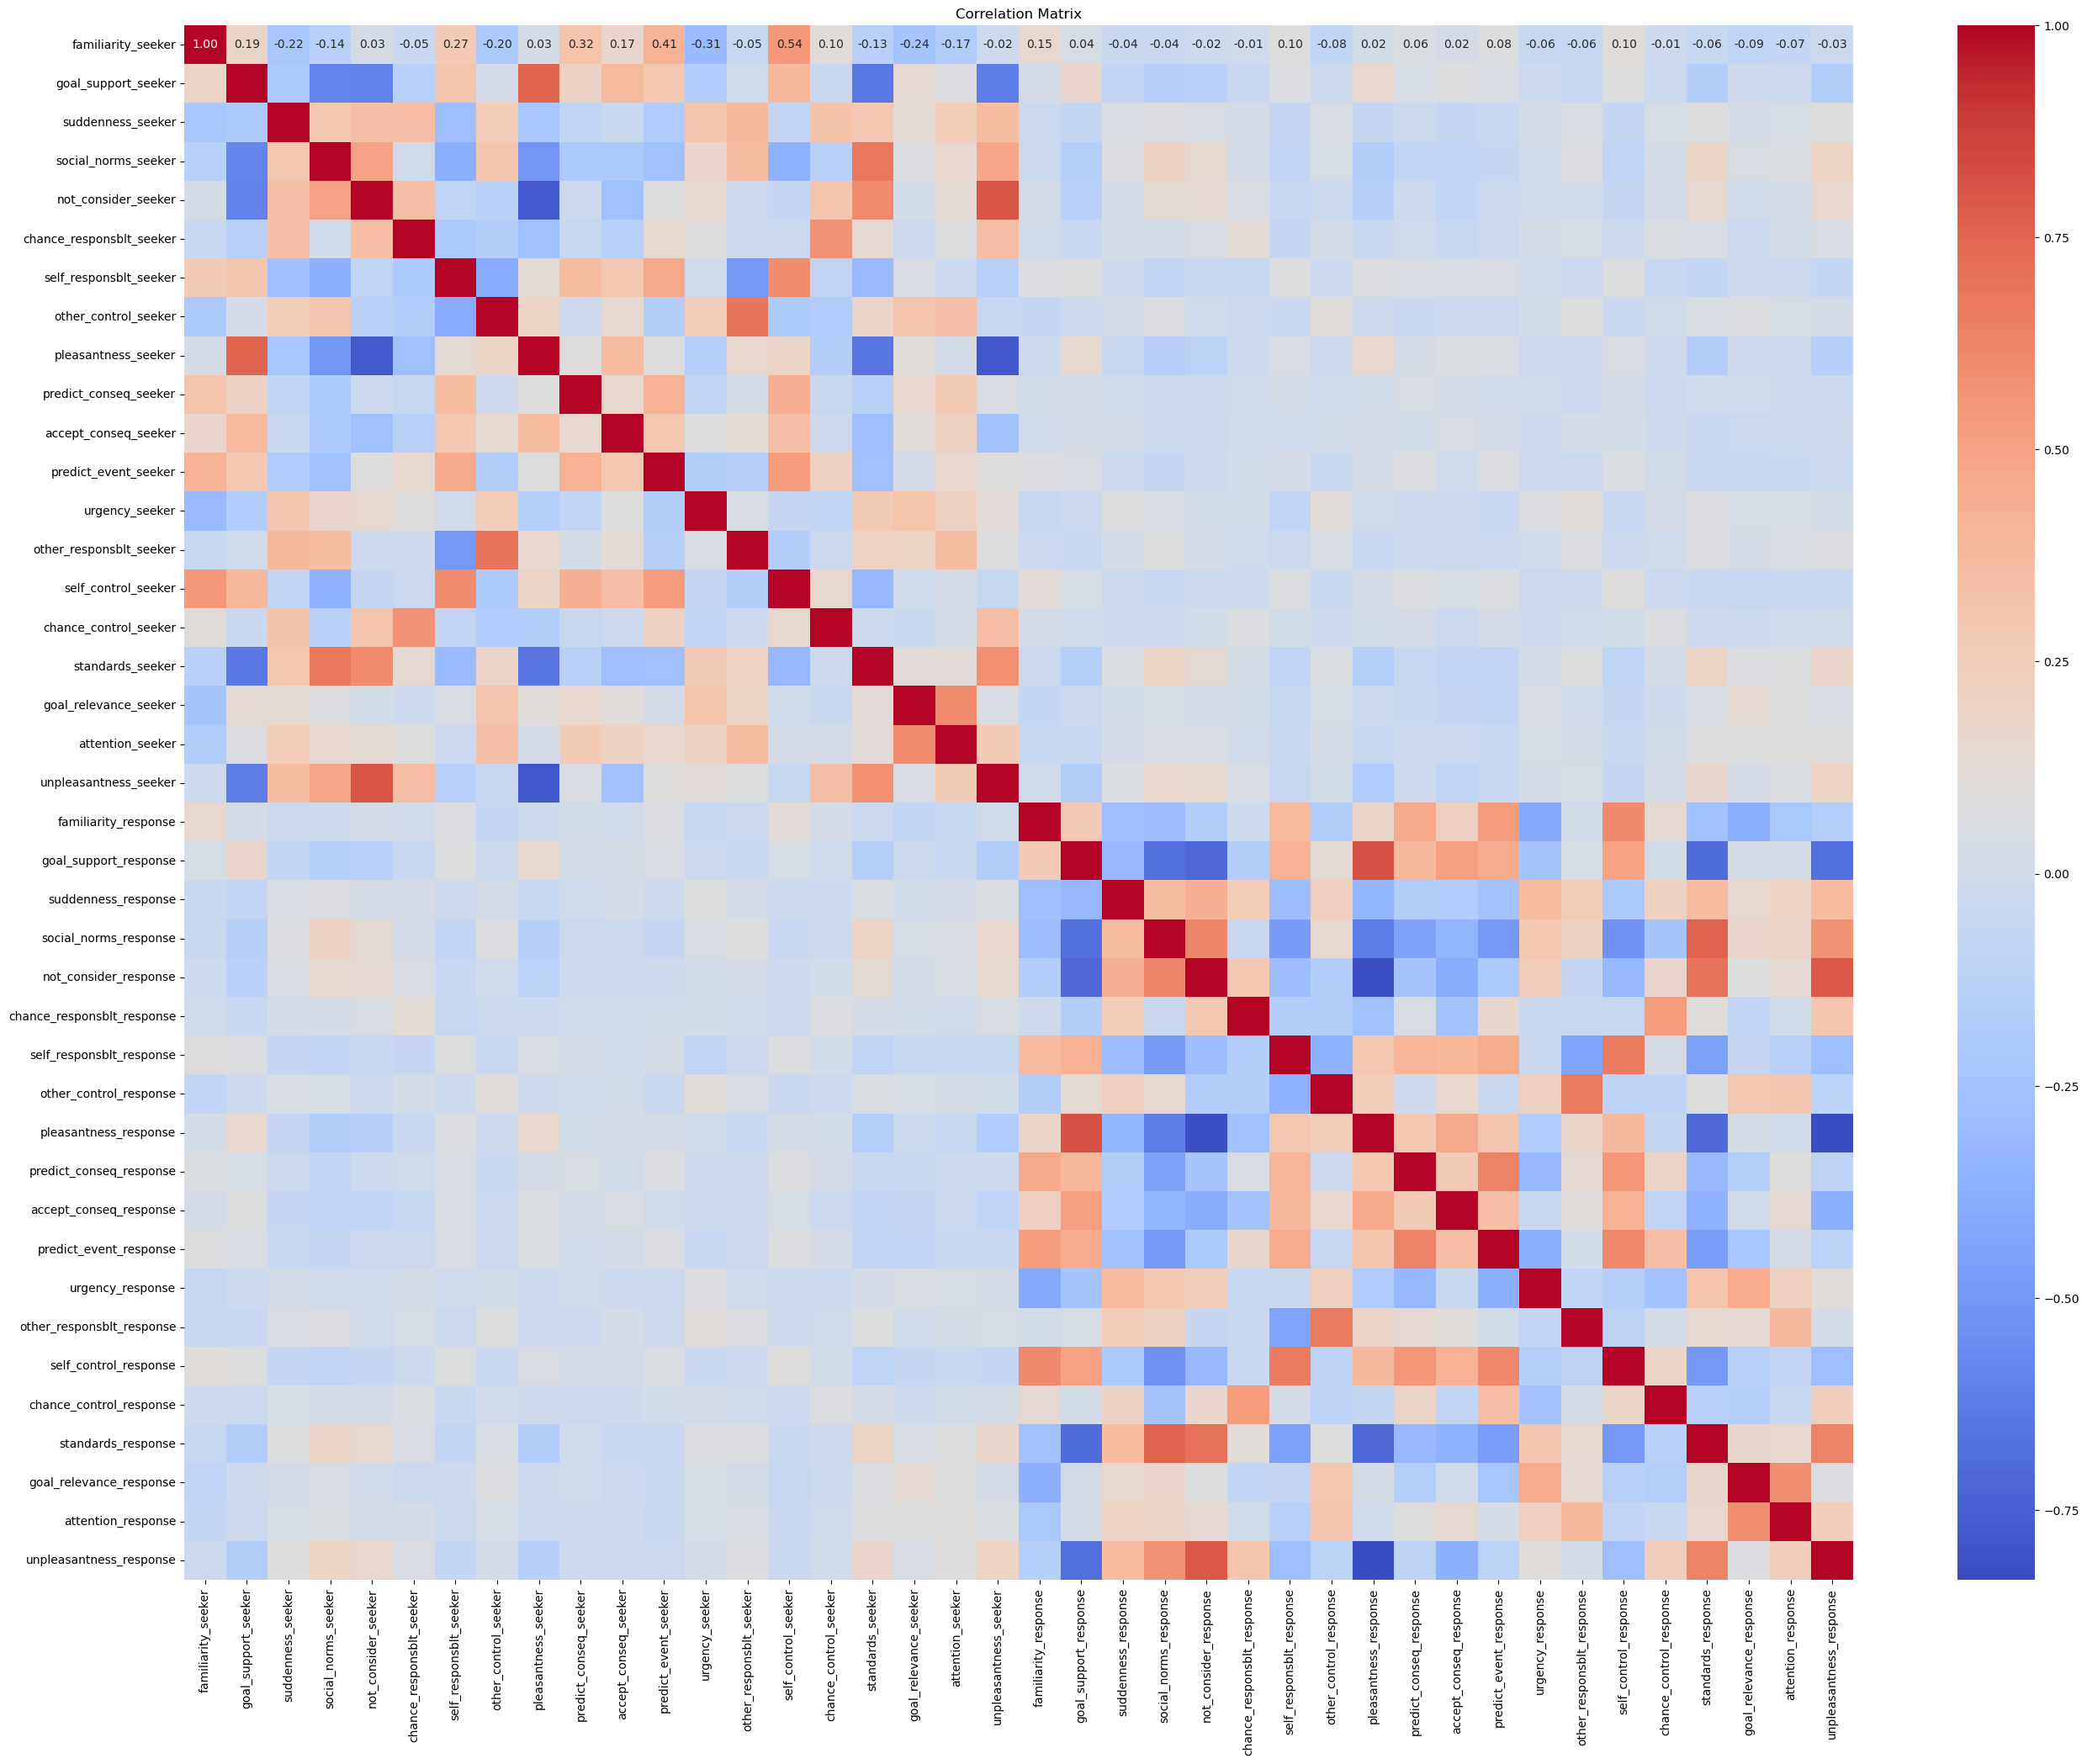

In [153]:
plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [45]:
import pandas as pd
pd.read_json('./dialogues/ALOE/ALOE train.json')

,id,subreddit,parent_id,target_id,target_text,observer_id,observer_text,full_text,distress_score,condolence_score,empathy_score,spans,alignments
0,1427,abusiverelationships,t3_o71cmx,o71cmx,Goodmorning….. today’s my day off and of cours...,h2w2wiy,"it doesn't work even if you try to avoid ""sayi...",target:\n\nGoodmorning….. today’s my day off a...,2.455078,2.111328,2.222656,"[[220, 253, Certainty, As expected he blew up ...","[[[441, 535, I at this point just have regrets..."
1,2428,BreakUp,t3_o4l9ct,o4l9ct,"One moment you’re fine and the next, you’re hi...",h2i4o81,Feel them.\n\nAccept the feelings. They’re val...,target:\n\nOne moment you’re fine and the next...,2.455078,1.343750,2.017578,"[[9, 101, Situational Control, One moment you’...","[[[9, 101, One moment you’re fine and the next..."
2,2623,depression,t3_o2qvme,o2qvme,My grandmother died a few days ago and it's so...,h288ita,"Was she ill for a long time? If so, you may ha...",target:\n\nMy grandmother died a few days ago ...,2.455078,1.356445,2.025391,"[[9, 43, Objective Experience, My grandmother ...","[[[9, 43, My grandmother died a few days ago],..."
3,2419,BreakUp,t3_o4r47z,o4r47z,"Sometimes I just wanna tell him everything, al...",h2ky4ze,Ouch. I’m sorry you are going through this. I’...,target:\n\nSometimes I just wanna tell him eve...,2.455078,1.028320,2.001953,"[[9, 131, Situational Control, Sometimes I jus...","[[[9, 131, Sometimes I just wanna tell him eve..."
4,1442,BreakUps,t3_o6sozq,o6sozq,My ex did a lot of things during our break up ...,h2v4xdp,Try to find peace in knowing that you did your...,target:\n\nMy ex did a lot of things during ou...,2.455078,2.132812,2.480469,"[[9, 101, Self-Other Agency, My ex did a lot o...","[[[431, 597, I changed careers for her when ou..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,2434,widowers,t3_o4jpgr,o4jpgr,I have a 7 year old daughter and a 9 year old ...,h2i6lk7,"Yes it’s very normal, and expect the different...",target:\n\nI have a 7 year old daughter and a ...,2.455078,2.189453,2.058594,"[[9, 319, Objective Experience, I have a 7 yea...","[[[789, 902, Is this normal? Is this the calm ..."
441,2622,MomForAMinute,t3_o2riru,o2riru,My IRL mom passed away 4 years ago when I was ...,h282ky0,"Hugs to you bro. Really, really sorry for the ...",target:\n\nMy IRL mom passed away 4 years ago ...,2.455078,2.388672,2.003906,"[[9, 57, Objective Experience, My IRL mom pass...","[[[1016, 1039, I don’t know what to do], [1485..."
442,2458,depression,t3_o45gcs,o45gcs,Father's day always depresses me. Its been mo...,h2ge96d,"Hey man, it seems that this holiday reminds yo...",target:\n\nFather's day always depresses me. ...,2.455078,2.128906,2.296875,"[[9, 140, Pleasantness, Father's day always de...","[[[1006, 1034, Its the same on my birthday.], ..."
443,2638,BreakUps,t3_o2k34k,o2k34k,How am I supposed to break up with him when I ...,h271ewj,You are not responsible for his feelings. Actu...,target:\n\nHow am I supposed to break up with ...,2.455078,2.173828,2.259766,"[[9, 80, Self-Other Agency, How am I supposed ...","[[[1904, 1916, I’m so lost.], [3342, 3365, Do ..."


In [183]:
cond_df = pd.read_csv('./dialogues/condolence/train.csv', low_memory=False)
cond_df = cond_df[['rating', 'target', 'observer', 'user1', 'user2']]
cond_df

,rating,target,observer,user1,user2
0,2.0,I'm in my last year of Uni &amp; Working to su...,I ran on a schedule like that my last semester...,2.0,2.0
1,1.0,I just want to accept that Im not good enough ...,"Dude, im so sorry you feel this way. I too dea...",1.0,1.0
2,1.5,"Well, we lost her tonight. I guess it was time.",I'm very sorry for your loss. I know it may n...,1.0,2.0
3,4.5,"It's definitely rough, something that seems tr...","I'm really sorry, man. Losing a pet can be wor...",5.0,4.0
4,1.0,"Well boys, a week ago I posted about getting t...","Hey man, was there a little while ago. It real...",1.0,1.0
...,...,...,...,...,...
796,1.5,She used to beat me as a kid because she thoug...,That was for you. I figured you had a reason. ...,2.0,1.0
797,2.0,My sister was too. We had to force her into an...,Don't blame yourself for not stepping in soone...,3.0,1.0
798,1.0,I’m working nearly full time and doing 15 hour...,Hey man I broke down my final semester and alm...,1.0,1.0
799,1.0,"I see, thank you for your input. Long distance...","Never, ever do LDR for someone else unless yo...",1.0,1.0


In [159]:
observer_list = list(cond_df['observer'])
target_list = list(cond_df['target'])
indexes = [(i + 1) % 2 for i in range(len(cond_df['observer']) * 2)]
utterance_list = []
for i in range(len(observer_list)):
    utterance_list.append(target_list[i])
    utterance_list.append(observer_list[i])

In [160]:
cond_appdf = {
             'indices':indexes, 
             'utterances':utterance_list
            }
cond_appdf = pd.DataFrame(cond_appdf)
cond_appdf

,indices,utterances
0,1,I'm in my last year of Uni &amp; Working to su...
1,0,I ran on a schedule like that my last semester...
2,1,I just want to accept that Im not good enough ...
3,0,"Dude, im so sorry you feel this way. I too dea..."
4,1,"Well, we lost her tonight. I guess it was time."
...,...,...
1597,0,Hey man I broke down my final semester and alm...
1598,1,"I see, thank you for your input. Long distance..."
1599,0,"Never, ever do LDR for someone else unless yo..."
1600,1,I’m sorry I was so overwhelmed when I posted t...


In [161]:
tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-small')
dirname = './models/google-t5/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cond_dataloader = create_dataloader(cond_appdf, tokenizer, dial_col='utterances')

for model_name in os.listdir(dirname):
    # model_name='./models/google-t5/suddenness_google-t5/'
    if '.ipy' in model_name:
        continue
    column = str.join('_', model_name.split('_')[:-1])
    print(column)
    model = AutoModelForSequenceClassification.from_pretrained(os.path.join('./models/google-t5/', model_name))
    model = model.to(device)
    app_store = []
    for batch in tqdm(cond_dataloader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    ).logits
        logits = list(itertools.chain.from_iterable(outputs.cpu().numpy().tolist()))
        logits = [(l*4)+1 for l in logits]
        app_store.extend(logits)
    cond_appdf[column] = app_store
    
    app_store = []
    # Cleanup
    model.to('cpu')
    del model
    torch.cuda.empty_cache()

familiarity


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.40it/s]


goal_support


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.81it/s]


suddenness


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.96it/s]


social_norms


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.68it/s]


not_consider


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.18it/s]


chance_responsblt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.67it/s]


self_responsblt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.20it/s]


other_control


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.40it/s]


pleasantness


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.08it/s]


predict_conseq


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.60it/s]


accept_conseq


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.56it/s]


predict_event


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.49it/s]


urgency


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.76it/s]


other_responsblt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.89it/s]


self_control


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.46it/s]


chance_control


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.33it/s]


standards


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.70it/s]


goal_relevance


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.68it/s]


attention


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.31it/s]


unpleasantness


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.13it/s]


In [176]:
cond_appdf

,indices,utterances,familiarity,goal_support,suddenness,social_norms,not_consider,chance_responsblt,self_responsblt,other_control,...,accept_conseq,predict_event,urgency,other_responsblt,self_control,chance_control,standards,goal_relevance,attention,unpleasantness
0,1,I'm in my last year of Uni &amp; Working to su...,3.014911,3.140760,1.991933,1.937905,1.903719,2.388342,3.438227,3.265068,...,3.427794,3.181520,2.734099,2.973767,3.082379,1.921872,2.150527,2.807578,3.340938,3.306859
1,0,I ran on a schedule like that my last semester...,2.752526,1.891509,3.230737,2.457424,3.224683,2.082618,2.577735,2.957307,...,3.159317,2.460164,3.542365,2.857728,2.320143,1.680311,3.105159,3.316473,3.818566,3.462589
2,1,I just want to accept that Im not good enough ...,3.321083,2.017783,3.060814,2.180864,2.807894,1.926144,3.177035,3.429943,...,3.223381,3.125553,2.974762,3.266007,2.490059,2.148280,2.495635,2.873060,3.647979,3.430080
3,0,"Dude, im so sorry you feel this way. I too dea...",2.673670,1.799785,3.370427,2.645305,3.329743,1.977631,2.298273,3.418799,...,3.143846,2.195781,3.768039,3.158473,2.284715,1.724280,3.199477,3.385449,3.610577,3.633552
4,1,"Well, we lost her tonight. I guess it was time.",2.652653,1.573017,3.339839,1.833211,2.900297,2.766547,2.479731,3.483082,...,2.885785,2.754670,3.779019,3.159863,2.243291,2.414108,2.911186,3.132494,3.343255,3.536445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,0,Hey man I broke down my final semester and alm...,3.021692,3.010200,2.792792,1.700506,2.361809,2.076865,3.459623,3.155321,...,3.339118,2.733082,3.139667,3.460143,2.909099,2.122660,1.865531,3.358238,3.718899,2.678891
1598,1,"I see, thank you for your input. Long distance...",2.653396,1.982543,3.283764,2.296421,2.943137,2.130988,2.587415,3.209758,...,3.149970,2.267821,3.705194,3.687036,2.014206,1.571196,3.212541,3.586309,3.763211,3.452103
1599,0,"Never, ever do LDR for someone else unless yo...",2.756003,1.741587,3.279159,2.567842,3.132153,2.034730,2.204605,3.490466,...,3.113135,2.146219,3.654075,3.747795,2.258734,1.714985,3.138132,3.367390,3.889829,3.650236
1600,1,I’m sorry I was so overwhelmed when I posted t...,2.792266,1.932902,3.330348,2.517897,3.278061,2.024336,2.251423,3.296005,...,3.134351,2.460481,3.645865,3.433457,2.399205,2.012522,3.332301,3.333388,3.896944,4.130566


In [177]:
target_df = cond_appdf[cond_appdf['indices'] == 1]
observer_df = cond_appdf[cond_appdf['indices'] == 0]
target_df.rename(columns={"utterances": "target"}, inplace=True)
observer_df.rename(columns={"utterances": "observer"}, inplace=True)

/tmp/ipykernel_811014/1940639004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df.rename(columns={"utterances": "target"}, inplace=True)
/tmp/ipykernel_811014/1940639004.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observer_df.rename(columns={"utterances": "observer"}, inplace=True)


In [178]:
target_df.reset_index(inplace=True)
observer_df.reset_index(inplace=True)

In [179]:
cond_df = pd.concat([cond_df, target_df], axis=1)
cond_df = pd.concat([cond_df, observer_df], axis=1)

In [180]:
cond_df

,rating,target,observer,user1,user2,index,indices,target,familiarity,goal_support,...,accept_conseq,predict_event,urgency,other_responsblt,self_control,chance_control,standards,goal_relevance,attention,unpleasantness
0,2.0,I'm in my last year of Uni &amp; Working to su...,I ran on a schedule like that my last semester...,2.0,2.0,0,1,I'm in my last year of Uni &amp; Working to su...,3.014911,3.140760,...,3.159317,2.460164,3.542365,2.857728,2.320143,1.680311,3.105159,3.316473,3.818566,3.462589
1,1.0,I just want to accept that Im not good enough ...,"Dude, im so sorry you feel this way. I too dea...",1.0,1.0,2,1,I just want to accept that Im not good enough ...,3.321083,2.017783,...,3.143846,2.195781,3.768039,3.158473,2.284715,1.724280,3.199477,3.385449,3.610577,3.633552
2,1.5,"Well, we lost her tonight. I guess it was time.",I'm very sorry for your loss. I know it may n...,1.0,2.0,4,1,"Well, we lost her tonight. I guess it was time.",2.652653,1.573017,...,3.197115,2.488864,3.696502,3.296235,2.202376,1.744605,3.308625,3.337676,3.675868,3.669883
3,4.5,"It's definitely rough, something that seems tr...","I'm really sorry, man. Losing a pet can be wor...",5.0,4.0,6,1,"It's definitely rough, something that seems tr...",2.653229,2.219774,...,2.943065,2.766086,3.256682,3.924454,2.870495,2.452656,3.378686,3.724453,4.078618,4.786934
4,1.0,"Well boys, a week ago I posted about getting t...","Hey man, was there a little while ago. It real...",1.0,1.0,8,1,"Well boys, a week ago I posted about getting t...",2.714128,2.010767,...,2.919209,2.103281,3.862847,3.400326,2.257352,2.144759,2.969266,3.442252,3.854364,4.060154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1.5,She used to beat me as a kid because she thoug...,That was for you. I figured you had a reason. ...,2.0,1.0,1592,1,She used to beat me as a kid because she thoug...,2.868839,1.828939,...,2.918030,2.192288,3.896577,3.285973,2.032299,1.730893,2.941102,3.506763,4.027478,3.615981
797,2.0,My sister was too. We had to force her into an...,Don't blame yourself for not stepping in soone...,3.0,1.0,1594,1,My sister was too. We had to force her into an...,2.751741,2.068546,...,3.115622,2.831864,3.062544,3.956001,2.230517,1.561915,3.190166,3.218892,3.970096,3.407173
798,1.0,I’m working nearly full time and doing 15 hour...,Hey man I broke down my final semester and alm...,1.0,1.0,1596,1,I’m working nearly full time and doing 15 hour...,3.037155,2.439081,...,3.339118,2.733082,3.139667,3.460143,2.909099,2.122660,1.865531,3.358238,3.718899,2.678891
799,1.0,"I see, thank you for your input. Long distance...","Never, ever do LDR for someone else unless yo...",1.0,1.0,1598,1,"I see, thank you for your input. Long distance...",2.653396,1.982543,...,3.113135,2.146219,3.654075,3.747795,2.258734,1.714985,3.138132,3.367390,3.889829,3.650236


In [181]:
cols = list(target_df.columns)
cols = cols[:3] + [col + '_target' for col in cols[3:]]
col_map = {list(target_df.columns)[i]:cols[i] for i in range(len(cols))}
target_df = target_df.rename(columns=col_map)
target_df

,index,indices,target,familiarity_target,goal_support_target,suddenness_target,social_norms_target,not_consider_target,chance_responsblt_target,self_responsblt_target,...,accept_conseq_target,predict_event_target,urgency_target,other_responsblt_target,self_control_target,chance_control_target,standards_target,goal_relevance_target,attention_target,unpleasantness_target
0,0,1,I'm in my last year of Uni &amp; Working to su...,3.014911,3.140760,1.991933,1.937905,1.903719,2.388342,3.438227,...,3.427794,3.181520,2.734099,2.973767,3.082379,1.921872,2.150527,2.807578,3.340938,3.306859
1,2,1,I just want to accept that Im not good enough ...,3.321083,2.017783,3.060814,2.180864,2.807894,1.926144,3.177035,...,3.223381,3.125553,2.974762,3.266007,2.490059,2.148280,2.495635,2.873060,3.647979,3.430080
2,4,1,"Well, we lost her tonight. I guess it was time.",2.652653,1.573017,3.339839,1.833211,2.900297,2.766547,2.479731,...,2.885785,2.754670,3.779019,3.159863,2.243291,2.414108,2.911186,3.132494,3.343255,3.536445
3,6,1,"It's definitely rough, something that seems tr...",2.653229,2.219774,3.156581,2.399057,3.452403,2.187362,2.780442,...,3.280745,2.371990,3.870464,3.552591,2.504988,2.483236,3.207265,3.626317,4.008646,4.335817
4,8,1,"Well boys, a week ago I posted about getting t...",2.714128,2.010767,2.957304,2.401450,3.179971,2.011328,2.366865,...,3.108711,2.419749,3.264117,3.557914,2.053838,1.952511,3.058571,3.359367,3.909853,3.594915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1592,1,She used to beat me as a kid because she thoug...,2.868839,1.828939,3.618840,2.226541,2.900627,1.887831,2.333198,...,3.120981,2.980100,3.507699,3.933182,2.488457,2.042283,2.858626,2.968273,3.696846,3.997539
797,1594,1,My sister was too. We had to force her into an...,2.751741,2.068546,3.812778,1.894568,3.044711,2.375084,1.925499,...,3.040270,2.699138,3.367786,3.677569,2.445723,2.583192,2.665285,3.086847,4.010242,4.091454
798,1596,1,I’m working nearly full time and doing 15 hour...,3.037155,2.439081,3.098199,2.040407,3.030870,2.044275,3.590126,...,3.266701,2.845173,2.971814,2.982539,2.805925,2.009767,2.530089,2.990472,3.569992,3.484865
799,1598,1,"I see, thank you for your input. Long distance...",2.653396,1.982543,3.283764,2.296421,2.943137,2.130988,2.587415,...,3.149970,2.267821,3.705194,3.687036,2.014206,1.571196,3.212541,3.586309,3.763211,3.452103


In [182]:
cols = list(observer_df.columns)
cols = cols[:3] + [col + '_observer' for col in cols[3:]]
col_map = {list(observer_df.columns)[i]:cols[i] for i in range(len(cols))}
observer_df = observer_df.rename(columns=col_map)
observer_df

,index,indices,observer,familiarity_observer,goal_support_observer,suddenness_observer,social_norms_observer,not_consider_observer,chance_responsblt_observer,self_responsblt_observer,...,accept_conseq_observer,predict_event_observer,urgency_observer,other_responsblt_observer,self_control_observer,chance_control_observer,standards_observer,goal_relevance_observer,attention_observer,unpleasantness_observer
0,1,0,I ran on a schedule like that my last semester...,2.752526,1.891509,3.230737,2.457424,3.224683,2.082618,2.577735,...,3.159317,2.460164,3.542365,2.857728,2.320143,1.680311,3.105159,3.316473,3.818566,3.462589
1,3,0,"Dude, im so sorry you feel this way. I too dea...",2.673670,1.799785,3.370427,2.645305,3.329743,1.977631,2.298273,...,3.143846,2.195781,3.768039,3.158473,2.284715,1.724280,3.199477,3.385449,3.610577,3.633552
2,5,0,I'm very sorry for your loss. I know it may n...,2.921235,1.592647,3.079653,2.439653,3.011406,2.183673,2.549985,...,3.197115,2.488864,3.696502,3.296235,2.202376,1.744605,3.308625,3.337676,3.675868,3.669883
3,7,0,"I'm really sorry, man. Losing a pet can be wor...",2.828444,2.125298,3.019322,2.531385,3.213034,2.065221,2.421109,...,2.943065,2.766086,3.256682,3.924454,2.870495,2.452656,3.378686,3.724453,4.078618,4.786934
4,9,0,"Hey man, was there a little while ago. It real...",2.500621,1.727943,3.539303,2.380378,3.271671,2.075096,2.284298,...,2.919209,2.103281,3.862847,3.400326,2.257352,2.144759,2.969266,3.442252,3.854364,4.060154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1593,0,That was for you. I figured you had a reason. ...,2.557811,1.731943,3.276705,2.526573,3.108257,2.000216,1.991483,...,2.918030,2.192288,3.896577,3.285973,2.032299,1.730893,2.941102,3.506763,4.027478,3.615981
797,1595,0,Don't blame yourself for not stepping in soone...,2.856990,2.159047,2.805330,2.132564,2.629880,2.259665,2.221294,...,3.115622,2.831864,3.062544,3.956001,2.230517,1.561915,3.190166,3.218892,3.970096,3.407173
798,1597,0,Hey man I broke down my final semester and alm...,3.021692,3.010200,2.792792,1.700506,2.361809,2.076865,3.459623,...,3.339118,2.733082,3.139667,3.460143,2.909099,2.122660,1.865531,3.358238,3.718899,2.678891
799,1599,0,"Never, ever do LDR for someone else unless yo...",2.756003,1.741587,3.279159,2.567842,3.132153,2.034730,2.204605,...,3.113135,2.146219,3.654075,3.747795,2.258734,1.714985,3.138132,3.367390,3.889829,3.650236


In [184]:
cond_df = pd.concat([cond_df, target_df], axis=1)
cond_df = pd.concat([cond_df, observer_df], axis=1)
cond_df

,rating,target,observer,user1,user2,index,indices,target,familiarity_target,goal_support_target,...,accept_conseq_observer,predict_event_observer,urgency_observer,other_responsblt_observer,self_control_observer,chance_control_observer,standards_observer,goal_relevance_observer,attention_observer,unpleasantness_observer
0,2.0,I'm in my last year of Uni &amp; Working to su...,I ran on a schedule like that my last semester...,2.0,2.0,0,1,I'm in my last year of Uni &amp; Working to su...,3.014911,3.140760,...,3.159317,2.460164,3.542365,2.857728,2.320143,1.680311,3.105159,3.316473,3.818566,3.462589
1,1.0,I just want to accept that Im not good enough ...,"Dude, im so sorry you feel this way. I too dea...",1.0,1.0,2,1,I just want to accept that Im not good enough ...,3.321083,2.017783,...,3.143846,2.195781,3.768039,3.158473,2.284715,1.724280,3.199477,3.385449,3.610577,3.633552
2,1.5,"Well, we lost her tonight. I guess it was time.",I'm very sorry for your loss. I know it may n...,1.0,2.0,4,1,"Well, we lost her tonight. I guess it was time.",2.652653,1.573017,...,3.197115,2.488864,3.696502,3.296235,2.202376,1.744605,3.308625,3.337676,3.675868,3.669883
3,4.5,"It's definitely rough, something that seems tr...","I'm really sorry, man. Losing a pet can be wor...",5.0,4.0,6,1,"It's definitely rough, something that seems tr...",2.653229,2.219774,...,2.943065,2.766086,3.256682,3.924454,2.870495,2.452656,3.378686,3.724453,4.078618,4.786934
4,1.0,"Well boys, a week ago I posted about getting t...","Hey man, was there a little while ago. It real...",1.0,1.0,8,1,"Well boys, a week ago I posted about getting t...",2.714128,2.010767,...,2.919209,2.103281,3.862847,3.400326,2.257352,2.144759,2.969266,3.442252,3.854364,4.060154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1.5,She used to beat me as a kid because she thoug...,That was for you. I figured you had a reason. ...,2.0,1.0,1592,1,She used to beat me as a kid because she thoug...,2.868839,1.828939,...,2.918030,2.192288,3.896577,3.285973,2.032299,1.730893,2.941102,3.506763,4.027478,3.615981
797,2.0,My sister was too. We had to force her into an...,Don't blame yourself for not stepping in soone...,3.0,1.0,1594,1,My sister was too. We had to force her into an...,2.751741,2.068546,...,3.115622,2.831864,3.062544,3.956001,2.230517,1.561915,3.190166,3.218892,3.970096,3.407173
798,1.0,I’m working nearly full time and doing 15 hour...,Hey man I broke down my final semester and alm...,1.0,1.0,1596,1,I’m working nearly full time and doing 15 hour...,3.037155,2.439081,...,3.339118,2.733082,3.139667,3.460143,2.909099,2.122660,1.865531,3.358238,3.718899,2.678891
799,1.0,"I see, thank you for your input. Long distance...","Never, ever do LDR for someone else unless yo...",1.0,1.0,1598,1,"I see, thank you for your input. Long distance...",2.653396,1.982543,...,3.113135,2.146219,3.654075,3.747795,2.258734,1.714985,3.138132,3.367390,3.889829,3.650236


In [185]:
cond_df.to_csv('./appraised_condolence.csv')

In [186]:
col_list = []
# col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
for col in cond_df.columns:
    if '_target' in col:
    # or '_level' in col:
        # or '_seeker' in col 
        col_list.append(col)

target_df = cond_df[col_list]
corr_matrix = target_df.corr()
print(corr_matrix)

                          familiarity_target  goal_support_target  \
familiarity_target                  1.000000             0.388667   
goal_support_target                 0.388667             1.000000   
suddenness_target                  -0.229359            -0.269181   
social_norms_target                -0.365987            -0.465330   
not_consider_target                -0.108446            -0.512754   
chance_responsblt_target            0.011426             0.018857   
self_responsblt_target              0.450908             0.374129   
other_control_target               -0.090409             0.036626   
pleasantness_target                 0.260952             0.616059   
predict_conseq_target               0.380749             0.391350   
accept_conseq_target                0.262138             0.429818   
predict_event_target                0.620224             0.386735   
urgency_target                     -0.578243            -0.338380   
other_responsblt_target           

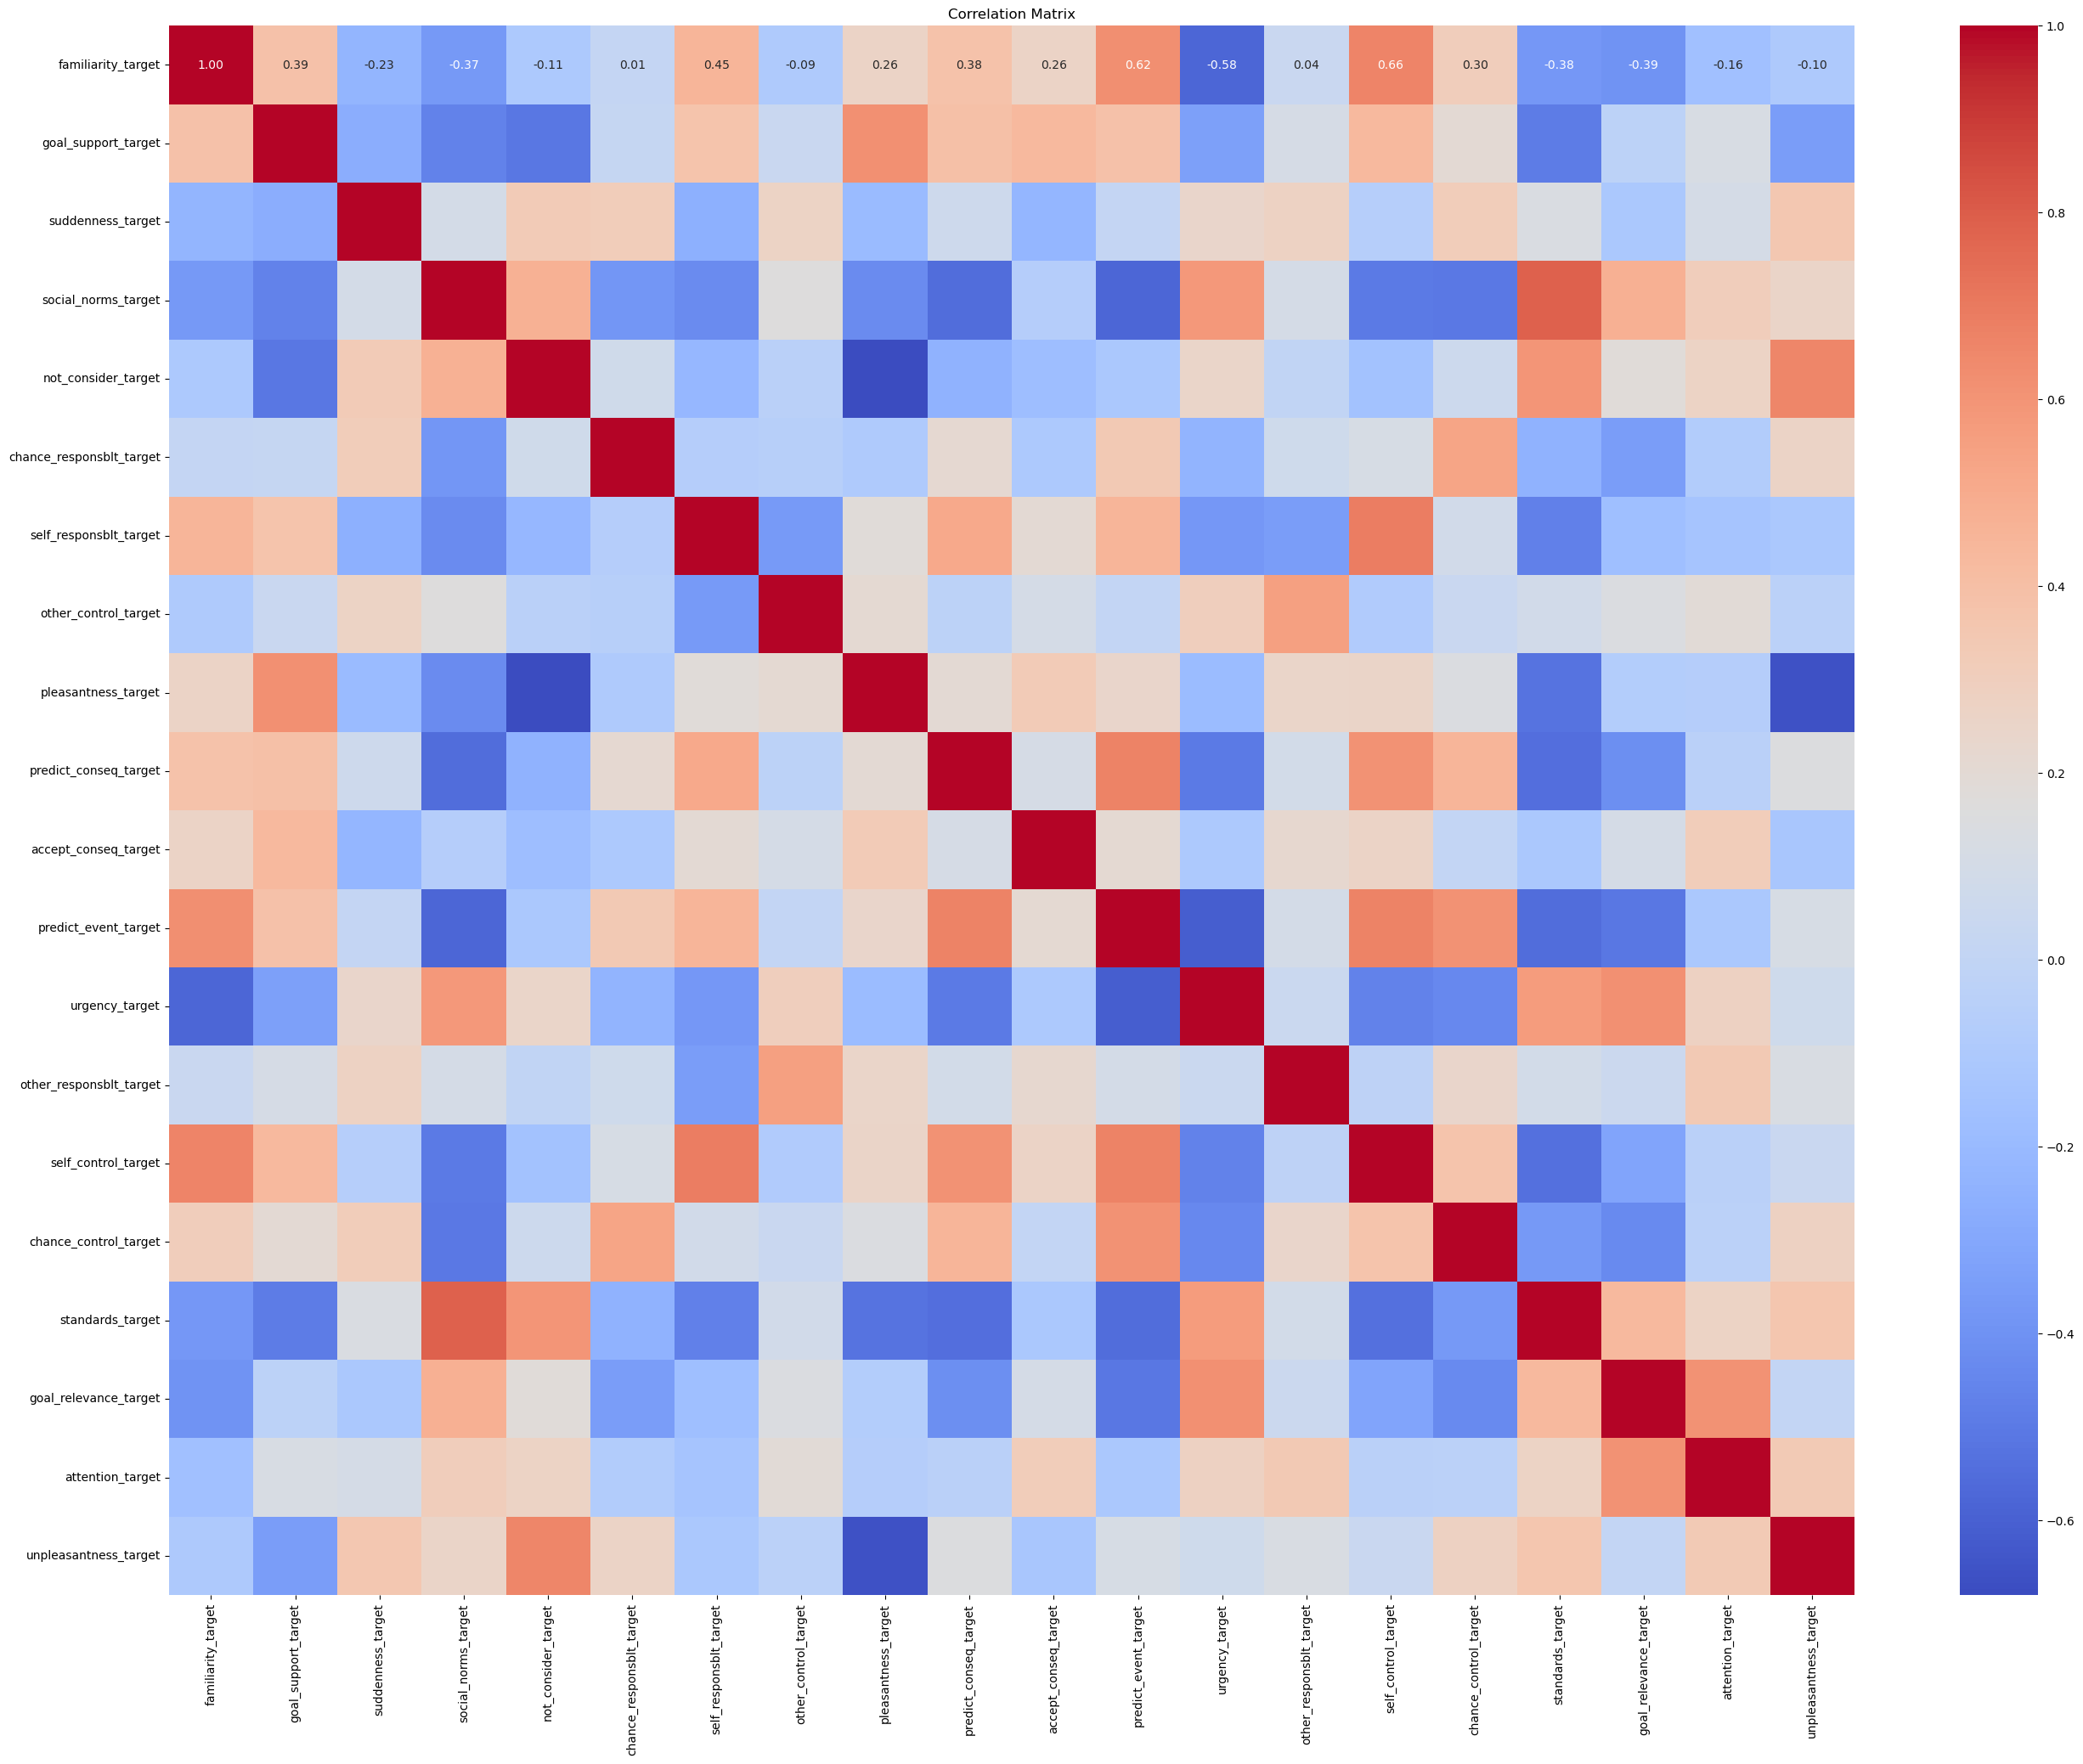

In [187]:
plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [188]:
col_list = []
# col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
for col in cond_df.columns:
    if '_observer' in col:
    # or '_level' in col:
        # or '_seeker' in col 
        col_list.append(col)

observer_df = cond_df[col_list]
corr_matrix = observer_df.corr()
print(corr_matrix)

                            familiarity_observer  goal_support_observer  \
familiarity_observer                    1.000000               0.365513   
goal_support_observer                   0.365513               1.000000   
suddenness_observer                    -0.262446              -0.244733   
social_norms_observer                  -0.492047              -0.557473   
not_consider_observer                  -0.222874              -0.580752   
chance_responsblt_observer              0.196957               0.045130   
self_responsblt_observer                0.326376               0.405149   
other_control_observer                 -0.120392              -0.076375   
pleasantness_observer                   0.381412               0.726373   
predict_conseq_observer                 0.447294               0.465852   
accept_conseq_observer                  0.363210               0.521179   
predict_event_observer                  0.610802               0.410916   
urgency_observer         

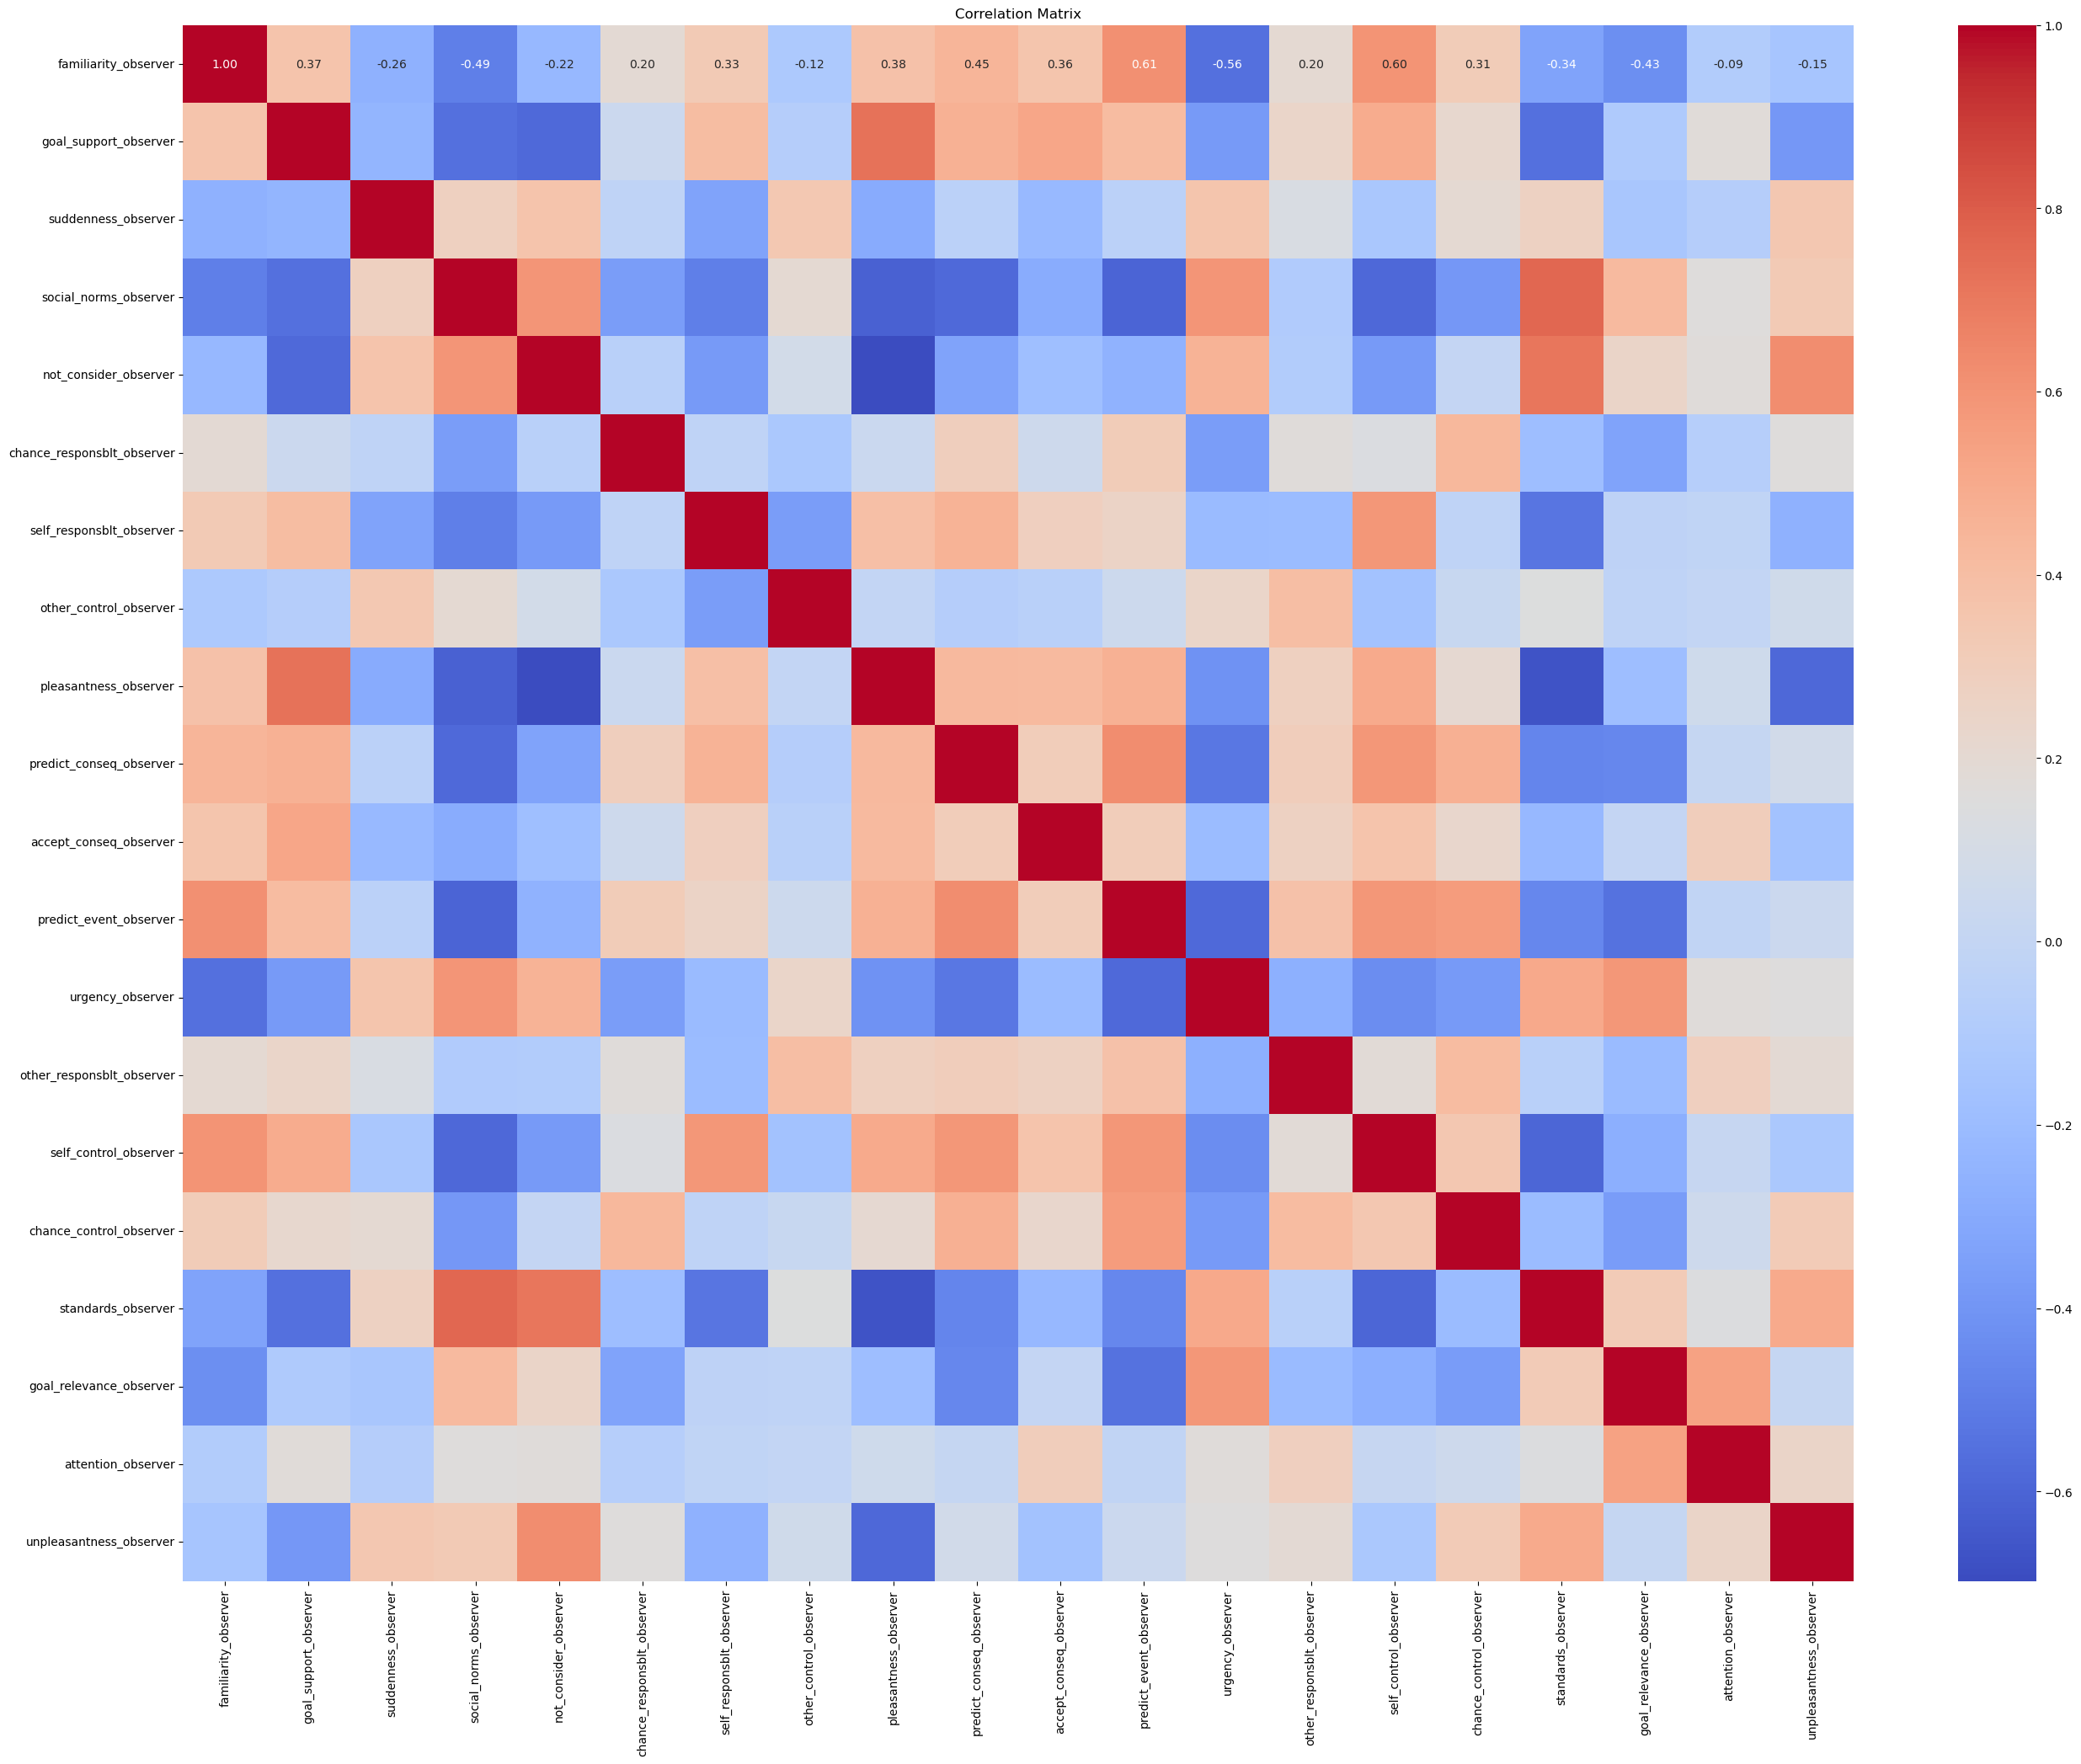

In [189]:
plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [194]:
col_list = []
# col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
for col in cond_df.columns:
    if '_observer' in col or '_target' in col:
    # or '_level' in col:
        # or '_seeker' in col 
        col_list.append(col)

observer_df = cond_df[col_list]
corr_matrix = observer_df.corr()
print(corr_matrix)

                            familiarity_target  goal_support_target  \
familiarity_target                    1.000000             0.388667   
goal_support_target                   0.388667             1.000000   
suddenness_target                    -0.229359            -0.269181   
social_norms_target                  -0.365987            -0.465330   
not_consider_target                  -0.108446            -0.512754   
chance_responsblt_target              0.011426             0.018857   
self_responsblt_target                0.450908             0.374129   
other_control_target                 -0.090409             0.036626   
pleasantness_target                   0.260952             0.616059   
predict_conseq_target                 0.380749             0.391350   
accept_conseq_target                  0.262138             0.429818   
predict_event_target                  0.620224             0.386735   
urgency_target                       -0.578243            -0.338380   
other_

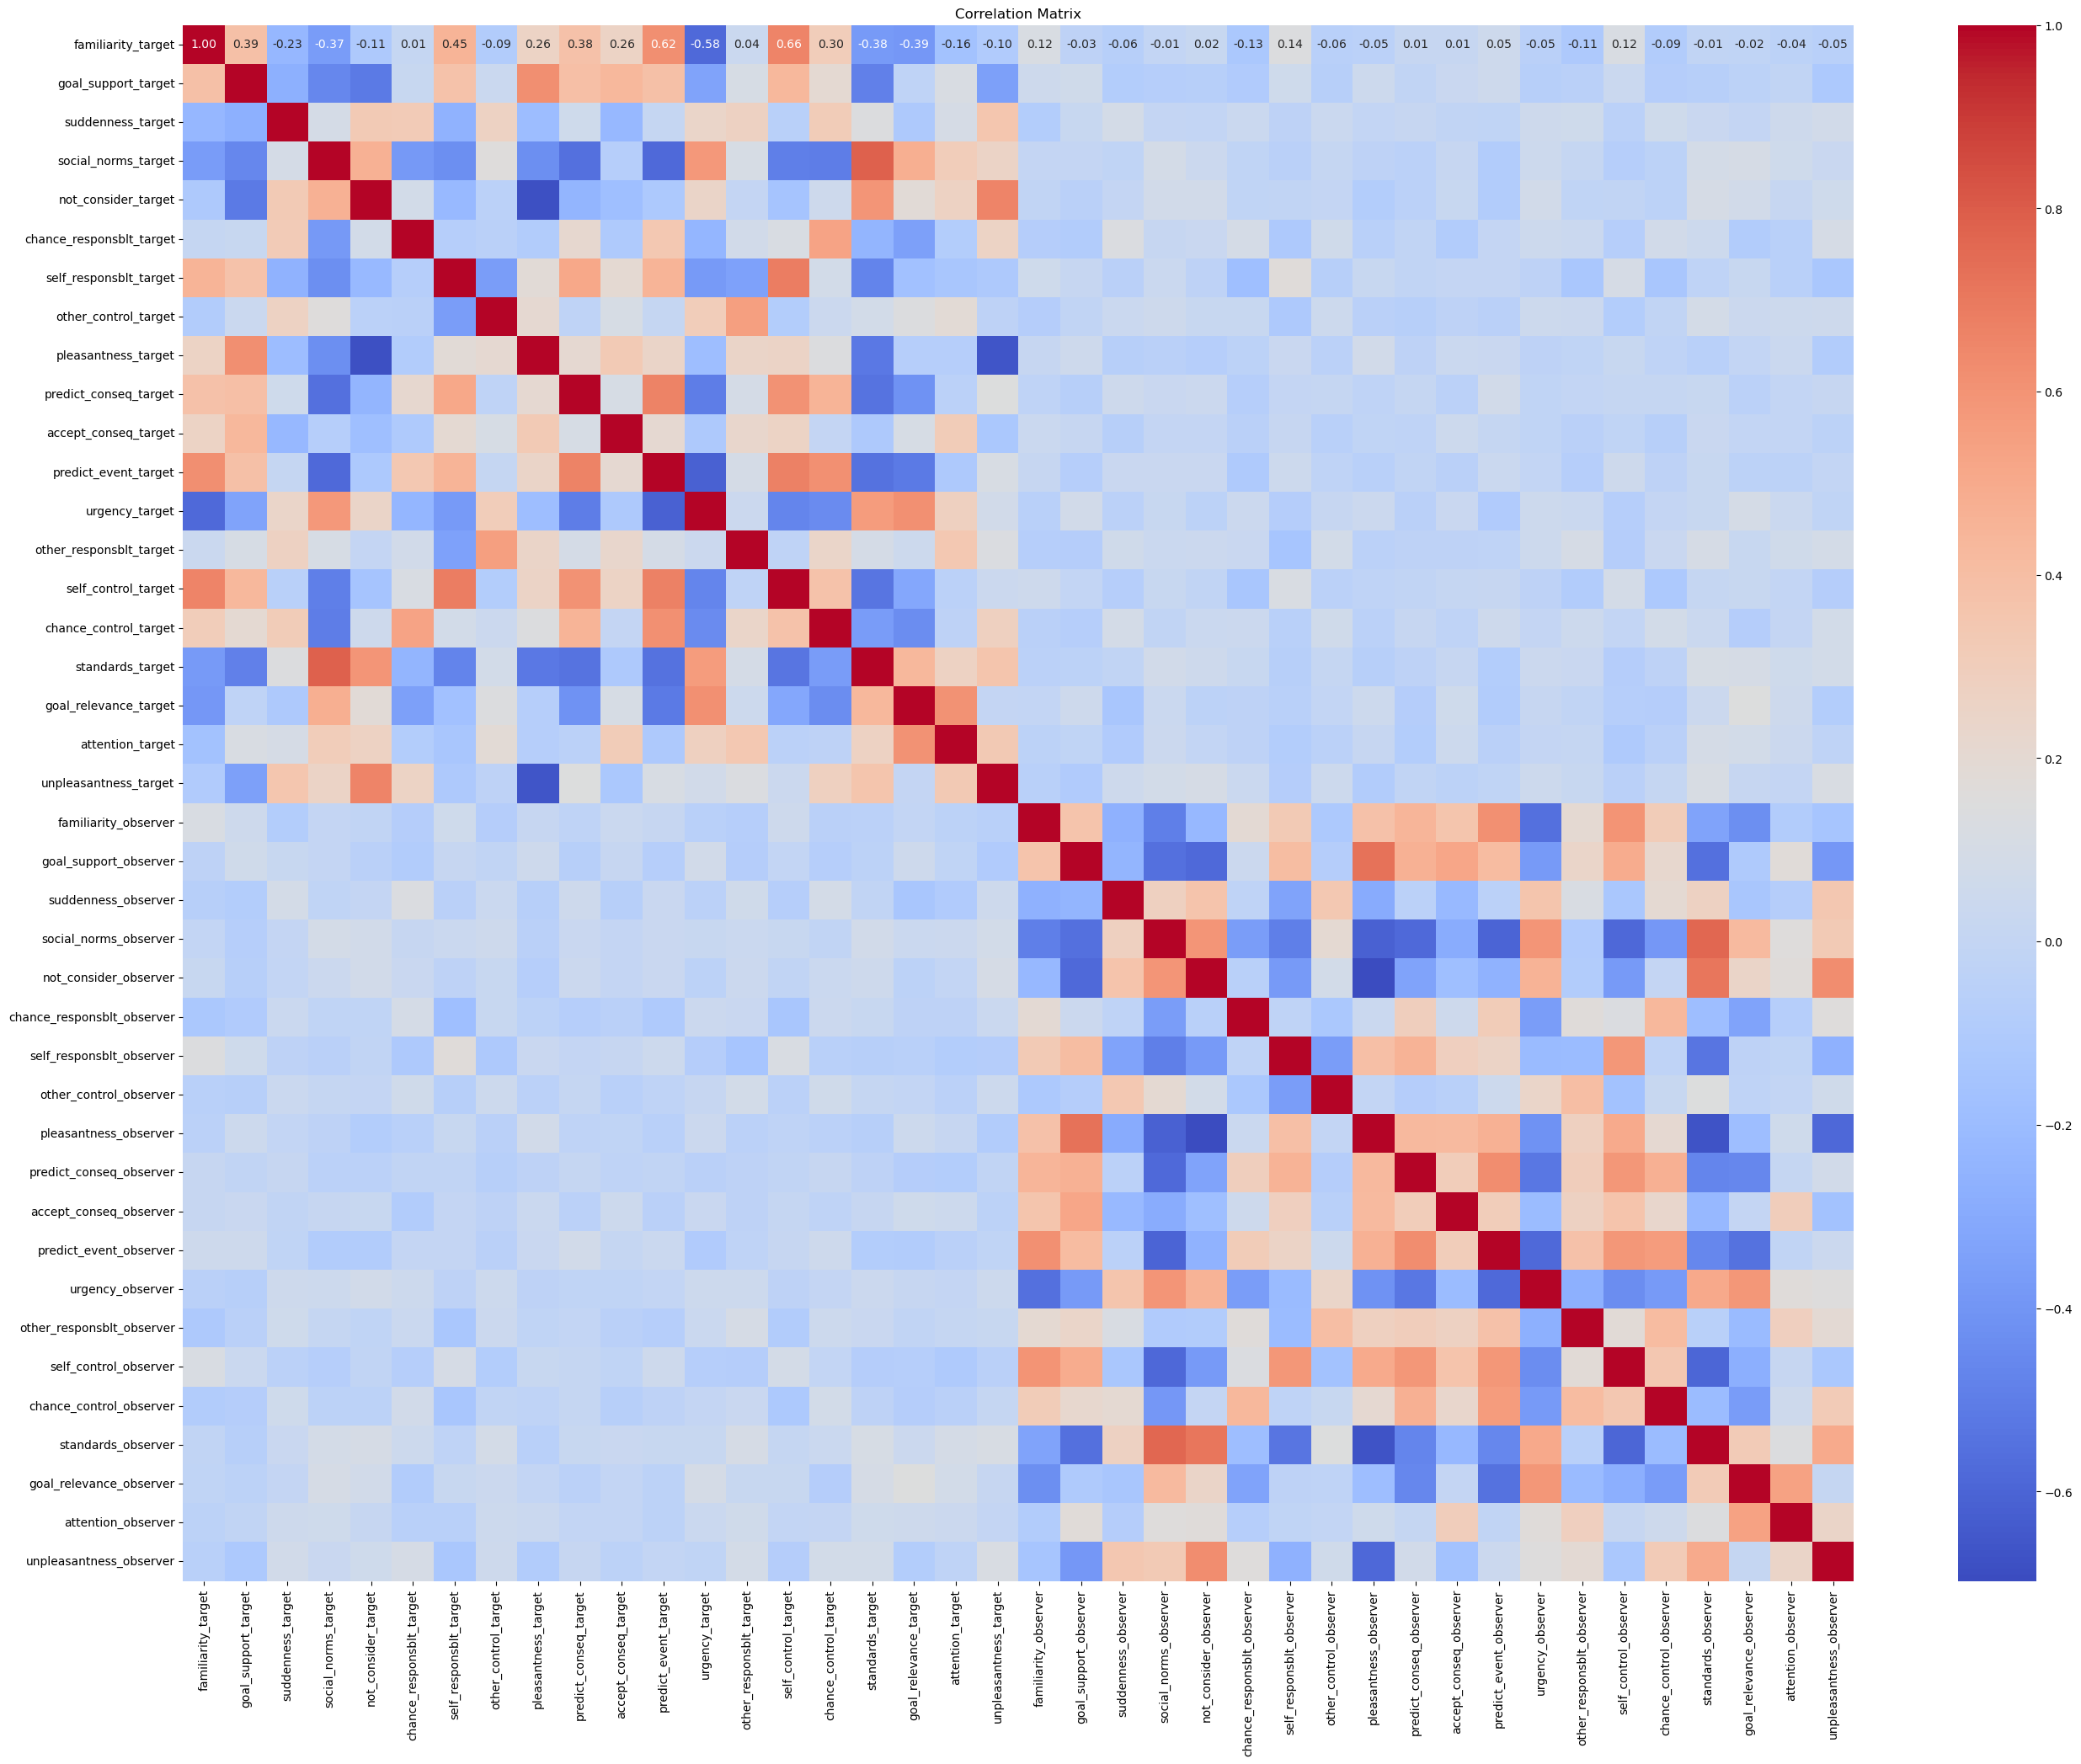

In [195]:
plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [19]:
aloe_df = pd.read_json('./dialogues/ALOE/ALOE train.json')
aloe_df = aloe_df[['target_text', 'observer_text', 'distress_score', 'condolence_score', 'empathy_score']]
aloe_df

,target_text,observer_text,distress_score,condolence_score,empathy_score
0,Goodmorning….. today’s my day off and of cours...,"it doesn't work even if you try to avoid ""sayi...",2.455078,2.111328,2.222656
1,"One moment you’re fine and the next, you’re hi...",Feel them.\n\nAccept the feelings. They’re val...,2.455078,1.343750,2.017578
2,My grandmother died a few days ago and it's so...,"Was she ill for a long time? If so, you may ha...",2.455078,1.356445,2.025391
3,"Sometimes I just wanna tell him everything, al...",Ouch. I’m sorry you are going through this. I’...,2.455078,1.028320,2.001953
4,My ex did a lot of things during our break up ...,Try to find peace in knowing that you did your...,2.455078,2.132812,2.480469
...,...,...,...,...,...
440,I have a 7 year old daughter and a 9 year old ...,"Yes it’s very normal, and expect the different...",2.455078,2.189453,2.058594
441,My IRL mom passed away 4 years ago when I was ...,"Hugs to you bro. Really, really sorry for the ...",2.455078,2.388672,2.003906
442,Father's day always depresses me. Its been mo...,"Hey man, it seems that this holiday reminds yo...",2.455078,2.128906,2.296875
443,How am I supposed to break up with him when I ...,You are not responsible for his feelings. Actu...,2.455078,2.173828,2.259766


In [6]:
observer_list = list(aloe_df['observer_text'])
target_list = list(aloe_df['target_text'])
indexes = [(i + 1) % 2 for i in range(len(aloe_df['observer_text']) * 2)]
utterance_list = []
for i in range(len(observer_list)):
    utterance_list.append(target_list[i])
    utterance_list.append(observer_list[i])

In [7]:
aloe_appdf = {
             'indices':indexes, 
             'utterances':utterance_list
            }
aloe_appdf = pd.DataFrame(aloe_appdf)
aloe_appdf

,indices,utterances
0,1,Goodmorning….. today’s my day off and of cours...
1,0,"it doesn't work even if you try to avoid ""sayi..."
2,1,"One moment you’re fine and the next, you’re hi..."
3,0,Feel them.\n\nAccept the feelings. They’re val...
4,1,My grandmother died a few days ago and it's so...
...,...,...
885,0,"Hey man, it seems that this holiday reminds yo..."
886,1,How am I supposed to break up with him when I ...
887,0,You are not responsible for his feelings. Actu...
888,1,Just woke up and for some reason my feelings o...


In [9]:
tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-small')
dirname = './models/google-t5/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
aloe_dataloader = create_dataloader(aloe_appdf, tokenizer, dial_col='utterances')

for model_name in os.listdir(dirname):
    # model_name='./models/google-t5/suddenness_google-t5/'
    if '.ipy' in model_name:
        continue
    column = str.join('_', model_name.split('_')[:-1])
    print(column)
    model = AutoModelForSequenceClassification.from_pretrained(os.path.join('./models/google-t5/', model_name))
    model = model.to(device)
    app_store = []
    for batch in tqdm(aloe_dataloader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    ).logits
        logits = list(itertools.chain.from_iterable(outputs.cpu().numpy().tolist()))
        logits = [(l*4)+1 for l in logits]
        app_store.extend(logits)
    aloe_appdf[column] = app_store
    
    app_store = []
    # Cleanup
    model.to('cpu')
    del model
    torch.cuda.empty_cache()

familiarity


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:04<00:00, 12.37it/s]


goal_support


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.08it/s]


suddenness


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.03it/s]


social_norms


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.07it/s]


not_consider


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.05it/s]


chance_responsblt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.04it/s]


self_responsblt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.99it/s]


other_control


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.99it/s]


pleasantness


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.91it/s]


predict_conseq


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.97it/s]


accept_conseq


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.93it/s]


predict_event


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.89it/s]


urgency


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.95it/s]


other_responsblt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.86it/s]


self_control


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.89it/s]


chance_control


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.91it/s]


standards


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.89it/s]


goal_relevance


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.90it/s]


attention


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.85it/s]


unpleasantness


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.84it/s]


In [10]:
aloe_appdf

,indices,utterances,familiarity,goal_support,suddenness,social_norms,not_consider,chance_responsblt,self_responsblt,other_control,...,accept_conseq,predict_event,urgency,other_responsblt,self_control,chance_control,standards,goal_relevance,attention,unpleasantness
0,1,Goodmorning….. today’s my day off and of cours...,2.944333,2.166275,3.441308,2.457967,3.250308,2.063328,2.392805,3.593477,...,3.225118,2.427254,3.736460,3.481415,2.388353,1.778512,3.223591,3.171150,3.717919,3.947360
1,0,"it doesn't work even if you try to avoid ""sayi...",2.732434,1.883850,3.136899,2.578751,3.382776,2.188572,2.274875,3.284063,...,3.045710,2.203780,3.692162,3.586367,2.167417,2.055283,3.313103,3.516466,4.003678,3.720733
2,1,"One moment you’re fine and the next, you’re hi...",3.272246,1.591452,3.105483,2.320705,3.615208,2.284192,2.899827,3.180173,...,3.211261,2.970256,3.453369,3.230982,3.188945,2.064484,3.088849,2.664794,3.545945,3.873296
3,0,Feel them.\n\nAccept the feelings. They’re val...,3.467073,2.878996,2.591616,1.956748,2.612135,1.994221,3.062557,3.104610,...,3.134486,3.106115,2.981231,3.701038,3.169661,1.448074,2.586455,3.220419,3.749599,2.769256
4,1,My grandmother died a few days ago and it's so...,2.453913,1.569493,3.393152,2.659059,3.233768,2.058688,2.105493,3.542235,...,3.021912,1.848135,3.973956,3.267020,1.896261,1.656666,3.174120,3.819679,3.743255,3.523808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,"Hey man, it seems that this holiday reminds yo...",3.143045,2.438971,2.977469,1.825778,2.697253,2.130578,2.606897,3.225990,...,3.428785,3.066746,2.749891,3.763857,2.551702,1.993464,2.578016,3.016257,3.629204,3.159668
886,1,How am I supposed to break up with him when I ...,2.890367,2.142578,2.783234,2.344607,2.966640,1.979674,2.426346,3.015905,...,3.089216,2.218356,3.496355,3.997982,2.433979,2.234847,3.090156,3.568881,4.053996,4.204567
887,0,You are not responsible for his feelings. Actu...,2.591450,1.853705,3.122459,2.667326,3.304993,1.982737,2.471358,3.513491,...,2.992090,2.197164,3.573246,3.747032,2.123395,1.273673,3.372128,3.530122,3.959467,3.490994
888,1,Just woke up and for some reason my feelings o...,2.582151,1.600543,3.679946,2.542486,3.179845,1.965622,2.395080,3.534804,...,2.932234,2.067740,3.821796,3.259323,2.259694,1.735404,3.114279,3.365342,3.620704,3.674944


In [12]:
target_df = aloe_appdf[aloe_appdf['indices'] == 1]
observer_df = aloe_appdf[aloe_appdf['indices'] == 0]
target_df.rename(columns={"utterances": "target_text"}, inplace=True)
observer_df.rename(columns={"utterances": "observer_text"}, inplace=True)

/tmp/ipykernel_668889/294466320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df.rename(columns={"utterances": "target_text"}, inplace=True)
/tmp/ipykernel_668889/294466320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observer_df.rename(columns={"utterances": "observer_text"}, inplace=True)


In [13]:
target_df.reset_index(inplace=True)
observer_df.reset_index(inplace=True)

In [14]:
aloe_df = pd.concat([aloe_df, target_df], axis=1)
aloe_df = pd.concat([aloe_df, observer_df], axis=1)

In [15]:
aloe_df

,target_text,observer_text,distress_score,condolence_score,empathy_score,index,indices,target_text,familiarity,goal_support,...,accept_conseq,predict_event,urgency,other_responsblt,self_control,chance_control,standards,goal_relevance,attention,unpleasantness
0,Goodmorning….. today’s my day off and of cours...,"it doesn't work even if you try to avoid ""sayi...",2.455078,2.111328,2.222656,0,1,Goodmorning….. today’s my day off and of cours...,2.944333,2.166275,...,3.045710,2.203780,3.692162,3.586367,2.167417,2.055283,3.313103,3.516466,4.003678,3.720733
1,"One moment you’re fine and the next, you’re hi...",Feel them.\n\nAccept the feelings. They’re val...,2.455078,1.343750,2.017578,2,1,"One moment you’re fine and the next, you’re hi...",3.272246,1.591452,...,3.134486,3.106115,2.981231,3.701038,3.169661,1.448074,2.586455,3.220419,3.749599,2.769256
2,My grandmother died a few days ago and it's so...,"Was she ill for a long time? If so, you may ha...",2.455078,1.356445,2.025391,4,1,My grandmother died a few days ago and it's so...,2.453913,1.569493,...,2.863941,2.172391,3.714714,3.433830,2.031414,2.003925,3.296677,3.567812,3.904866,3.903016
3,"Sometimes I just wanna tell him everything, al...",Ouch. I’m sorry you are going through this. I’...,2.455078,1.028320,2.001953,6,1,"Sometimes I just wanna tell him everything, al...",3.137810,2.294590,...,2.567440,2.465548,2.929438,3.384330,2.581440,1.781015,3.079610,2.947374,3.253726,3.955260
4,My ex did a lot of things during our break up ...,Try to find peace in knowing that you did your...,2.455078,2.132812,2.480469,8,1,My ex did a lot of things during our break up ...,2.212861,1.855574,...,2.764821,3.187980,3.431133,4.108836,2.323183,2.817302,3.687823,3.408082,4.227792,5.179562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,I have a 7 year old daughter and a 9 year old ...,"Yes it’s very normal, and expect the different...",2.455078,2.189453,2.058594,880,1,I have a 7 year old daughter and a 9 year old ...,2.648517,2.328614,...,2.900898,2.003580,3.723593,2.870662,2.248575,1.317254,3.044449,3.529205,3.762491,3.176034
441,My IRL mom passed away 4 years ago when I was ...,"Hugs to you bro. Really, really sorry for the ...",2.455078,2.388672,2.003906,882,1,My IRL mom passed away 4 years ago when I was ...,2.737527,1.944354,...,2.432163,1.960563,3.277681,2.619379,2.383837,2.094415,2.538582,3.206351,3.226370,2.708629
442,Father's day always depresses me. Its been mo...,"Hey man, it seems that this holiday reminds yo...",2.455078,2.128906,2.296875,884,1,Father's day always depresses me. Its been mo...,2.552532,2.431895,...,3.428785,3.066746,2.749891,3.763857,2.551702,1.993464,2.578016,3.016257,3.629204,3.159668
443,How am I supposed to break up with him when I ...,You are not responsible for his feelings. Actu...,2.455078,2.173828,2.259766,886,1,How am I supposed to break up with him when I ...,2.890367,2.142578,...,2.992090,2.197164,3.573246,3.747032,2.123395,1.273673,3.372128,3.530122,3.959467,3.490994


In [16]:
cols = list(target_df.columns)
cols = cols[:3] + [col + '_target' for col in cols[3:]]
col_map = {list(target_df.columns)[i]:cols[i] for i in range(len(cols))}
target_df = target_df.rename(columns=col_map)
target_df

,index,indices,target_text,familiarity_target,goal_support_target,suddenness_target,social_norms_target,not_consider_target,chance_responsblt_target,self_responsblt_target,...,accept_conseq_target,predict_event_target,urgency_target,other_responsblt_target,self_control_target,chance_control_target,standards_target,goal_relevance_target,attention_target,unpleasantness_target
0,0,1,Goodmorning….. today’s my day off and of cours...,2.944333,2.166275,3.441308,2.457967,3.250308,2.063328,2.392805,...,3.225118,2.427254,3.736460,3.481415,2.388353,1.778512,3.223591,3.171150,3.717919,3.947360
1,2,1,"One moment you’re fine and the next, you’re hi...",3.272246,1.591452,3.105483,2.320705,3.615208,2.284192,2.899827,...,3.211261,2.970256,3.453369,3.230982,3.188945,2.064484,3.088849,2.664794,3.545945,3.873296
2,4,1,My grandmother died a few days ago and it's so...,2.453913,1.569493,3.393152,2.659059,3.233768,2.058688,2.105493,...,3.021912,1.848135,3.973956,3.267020,1.896261,1.656666,3.174120,3.819679,3.743255,3.523808
3,6,1,"Sometimes I just wanna tell him everything, al...",3.137810,2.294590,3.030071,2.291529,2.645765,2.012924,2.871070,...,3.207087,2.524827,3.413364,3.362948,2.467667,1.666182,3.039375,3.266947,3.860250,3.057812
4,8,1,My ex did a lot of things during our break up ...,2.212861,1.855574,3.186579,2.253242,3.427068,2.078525,2.812758,...,3.366324,2.042094,3.633938,3.221510,2.243245,1.315612,3.411386,4.133238,3.921236,3.968159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,880,1,I have a 7 year old daughter and a 9 year old ...,2.648517,2.328614,2.780472,2.491497,2.639215,2.093819,2.050169,...,3.017159,2.253534,3.349673,3.284397,1.686055,1.649669,3.082056,3.137434,3.691055,3.349813
441,882,1,My IRL mom passed away 4 years ago when I was ...,2.737527,1.944354,3.078565,2.164942,2.859539,2.197075,2.674916,...,3.102339,2.172470,3.766082,3.640701,2.519011,2.540700,2.835413,3.622127,4.098073,2.904883
442,884,1,Father's day always depresses me. Its been mo...,2.552532,2.431895,2.723483,2.199984,2.676609,1.936355,2.424293,...,3.135887,2.067871,3.205472,3.071088,1.540072,1.788732,2.643625,3.119402,3.577280,3.666049
443,886,1,How am I supposed to break up with him when I ...,2.890367,2.142578,2.783234,2.344607,2.966640,1.979674,2.426346,...,3.089216,2.218356,3.496355,3.997982,2.433979,2.234847,3.090156,3.568881,4.053996,4.204567


In [17]:
cols = list(observer_df.columns)
cols = cols[:3] + [col + '_observer' for col in cols[3:]]
col_map = {list(observer_df.columns)[i]:cols[i] for i in range(len(cols))}
observer_df = observer_df.rename(columns=col_map)
observer_df

,index,indices,observer_text,familiarity_observer,goal_support_observer,suddenness_observer,social_norms_observer,not_consider_observer,chance_responsblt_observer,self_responsblt_observer,...,accept_conseq_observer,predict_event_observer,urgency_observer,other_responsblt_observer,self_control_observer,chance_control_observer,standards_observer,goal_relevance_observer,attention_observer,unpleasantness_observer
0,1,0,"it doesn't work even if you try to avoid ""sayi...",2.732434,1.883850,3.136899,2.578751,3.382776,2.188572,2.274875,...,3.045710,2.203780,3.692162,3.586367,2.167417,2.055283,3.313103,3.516466,4.003678,3.720733
1,3,0,Feel them.\n\nAccept the feelings. They’re val...,3.467073,2.878996,2.591616,1.956748,2.612135,1.994221,3.062557,...,3.134486,3.106115,2.981231,3.701038,3.169661,1.448074,2.586455,3.220419,3.749599,2.769256
2,5,0,"Was she ill for a long time? If so, you may ha...",2.661282,1.657869,3.422399,2.541835,3.345479,2.193743,1.956390,...,2.863941,2.172391,3.714714,3.433830,2.031414,2.003925,3.296677,3.567812,3.904866,3.903016
3,7,0,Ouch. I’m sorry you are going through this. I’...,3.049674,1.216561,2.907606,2.265431,3.068798,2.333528,2.730795,...,2.567440,2.465548,2.929438,3.384330,2.581440,1.781015,3.079610,2.947374,3.253726,3.955260
4,9,0,Try to find peace in knowing that you did your...,2.586283,1.965203,3.701200,2.420960,3.752372,2.915581,1.998431,...,2.764821,3.187980,3.431133,4.108836,2.323183,2.817302,3.687823,3.408082,4.227792,5.179562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,881,0,"Yes it’s very normal, and expect the different...",2.768546,1.638678,3.143669,2.581696,3.074642,2.047166,2.380281,...,2.900898,2.003580,3.723593,2.870662,2.248575,1.317254,3.044449,3.529205,3.762491,3.176034
441,883,0,"Hugs to you bro. Really, really sorry for the ...",2.547437,1.678527,2.850013,1.728195,2.694470,2.025061,2.293233,...,2.432163,1.960563,3.277681,2.619379,2.383837,2.094415,2.538582,3.206351,3.226370,2.708629
442,885,0,"Hey man, it seems that this holiday reminds yo...",3.143045,2.438971,2.977469,1.825778,2.697253,2.130578,2.606897,...,3.428785,3.066746,2.749891,3.763857,2.551702,1.993464,2.578016,3.016257,3.629204,3.159668
443,887,0,You are not responsible for his feelings. Actu...,2.591450,1.853705,3.122459,2.667326,3.304993,1.982737,2.471358,...,2.992090,2.197164,3.573246,3.747032,2.123395,1.273673,3.372128,3.530122,3.959467,3.490994


In [20]:
aloe_df = pd.concat([aloe_df, target_df], axis=1)
aloe_df = pd.concat([aloe_df, observer_df], axis=1)
aloe_df

,target_text,observer_text,distress_score,condolence_score,empathy_score,index,indices,target_text,familiarity_target,goal_support_target,...,accept_conseq_observer,predict_event_observer,urgency_observer,other_responsblt_observer,self_control_observer,chance_control_observer,standards_observer,goal_relevance_observer,attention_observer,unpleasantness_observer
0,Goodmorning….. today’s my day off and of cours...,"it doesn't work even if you try to avoid ""sayi...",2.455078,2.111328,2.222656,0,1,Goodmorning….. today’s my day off and of cours...,2.944333,2.166275,...,3.045710,2.203780,3.692162,3.586367,2.167417,2.055283,3.313103,3.516466,4.003678,3.720733
1,"One moment you’re fine and the next, you’re hi...",Feel them.\n\nAccept the feelings. They’re val...,2.455078,1.343750,2.017578,2,1,"One moment you’re fine and the next, you’re hi...",3.272246,1.591452,...,3.134486,3.106115,2.981231,3.701038,3.169661,1.448074,2.586455,3.220419,3.749599,2.769256
2,My grandmother died a few days ago and it's so...,"Was she ill for a long time? If so, you may ha...",2.455078,1.356445,2.025391,4,1,My grandmother died a few days ago and it's so...,2.453913,1.569493,...,2.863941,2.172391,3.714714,3.433830,2.031414,2.003925,3.296677,3.567812,3.904866,3.903016
3,"Sometimes I just wanna tell him everything, al...",Ouch. I’m sorry you are going through this. I’...,2.455078,1.028320,2.001953,6,1,"Sometimes I just wanna tell him everything, al...",3.137810,2.294590,...,2.567440,2.465548,2.929438,3.384330,2.581440,1.781015,3.079610,2.947374,3.253726,3.955260
4,My ex did a lot of things during our break up ...,Try to find peace in knowing that you did your...,2.455078,2.132812,2.480469,8,1,My ex did a lot of things during our break up ...,2.212861,1.855574,...,2.764821,3.187980,3.431133,4.108836,2.323183,2.817302,3.687823,3.408082,4.227792,5.179562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,I have a 7 year old daughter and a 9 year old ...,"Yes it’s very normal, and expect the different...",2.455078,2.189453,2.058594,880,1,I have a 7 year old daughter and a 9 year old ...,2.648517,2.328614,...,2.900898,2.003580,3.723593,2.870662,2.248575,1.317254,3.044449,3.529205,3.762491,3.176034
441,My IRL mom passed away 4 years ago when I was ...,"Hugs to you bro. Really, really sorry for the ...",2.455078,2.388672,2.003906,882,1,My IRL mom passed away 4 years ago when I was ...,2.737527,1.944354,...,2.432163,1.960563,3.277681,2.619379,2.383837,2.094415,2.538582,3.206351,3.226370,2.708629
442,Father's day always depresses me. Its been mo...,"Hey man, it seems that this holiday reminds yo...",2.455078,2.128906,2.296875,884,1,Father's day always depresses me. Its been mo...,2.552532,2.431895,...,3.428785,3.066746,2.749891,3.763857,2.551702,1.993464,2.578016,3.016257,3.629204,3.159668
443,How am I supposed to break up with him when I ...,You are not responsible for his feelings. Actu...,2.455078,2.173828,2.259766,886,1,How am I supposed to break up with him when I ...,2.890367,2.142578,...,2.992090,2.197164,3.573246,3.747032,2.123395,1.273673,3.372128,3.530122,3.959467,3.490994


In [21]:
col_list = []
# col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
for col in aloe_df.columns:
    if '_target' in col:
    # or '_level' in col:
        # or '_seeker' in col 
        col_list.append(col)

target_df = aloe_df[col_list]
corr_matrix = target_df.corr()
print(corr_matrix)

                          familiarity_target  goal_support_target  \
familiarity_target                  1.000000             0.287026   
goal_support_target                 0.287026             1.000000   
suddenness_target                  -0.158800            -0.206503   
social_norms_target                -0.419665            -0.570086   
not_consider_target                -0.083996            -0.567192   
chance_responsblt_target            0.151659             0.049213   
self_responsblt_target              0.394289             0.295152   
other_control_target               -0.205078            -0.084562   
pleasantness_target                 0.255245             0.699817   
predict_conseq_target               0.493192             0.291364   
accept_conseq_target                0.300098             0.300921   
predict_event_target                0.627541             0.358780   
urgency_target                     -0.627047            -0.378576   
other_responsblt_target           

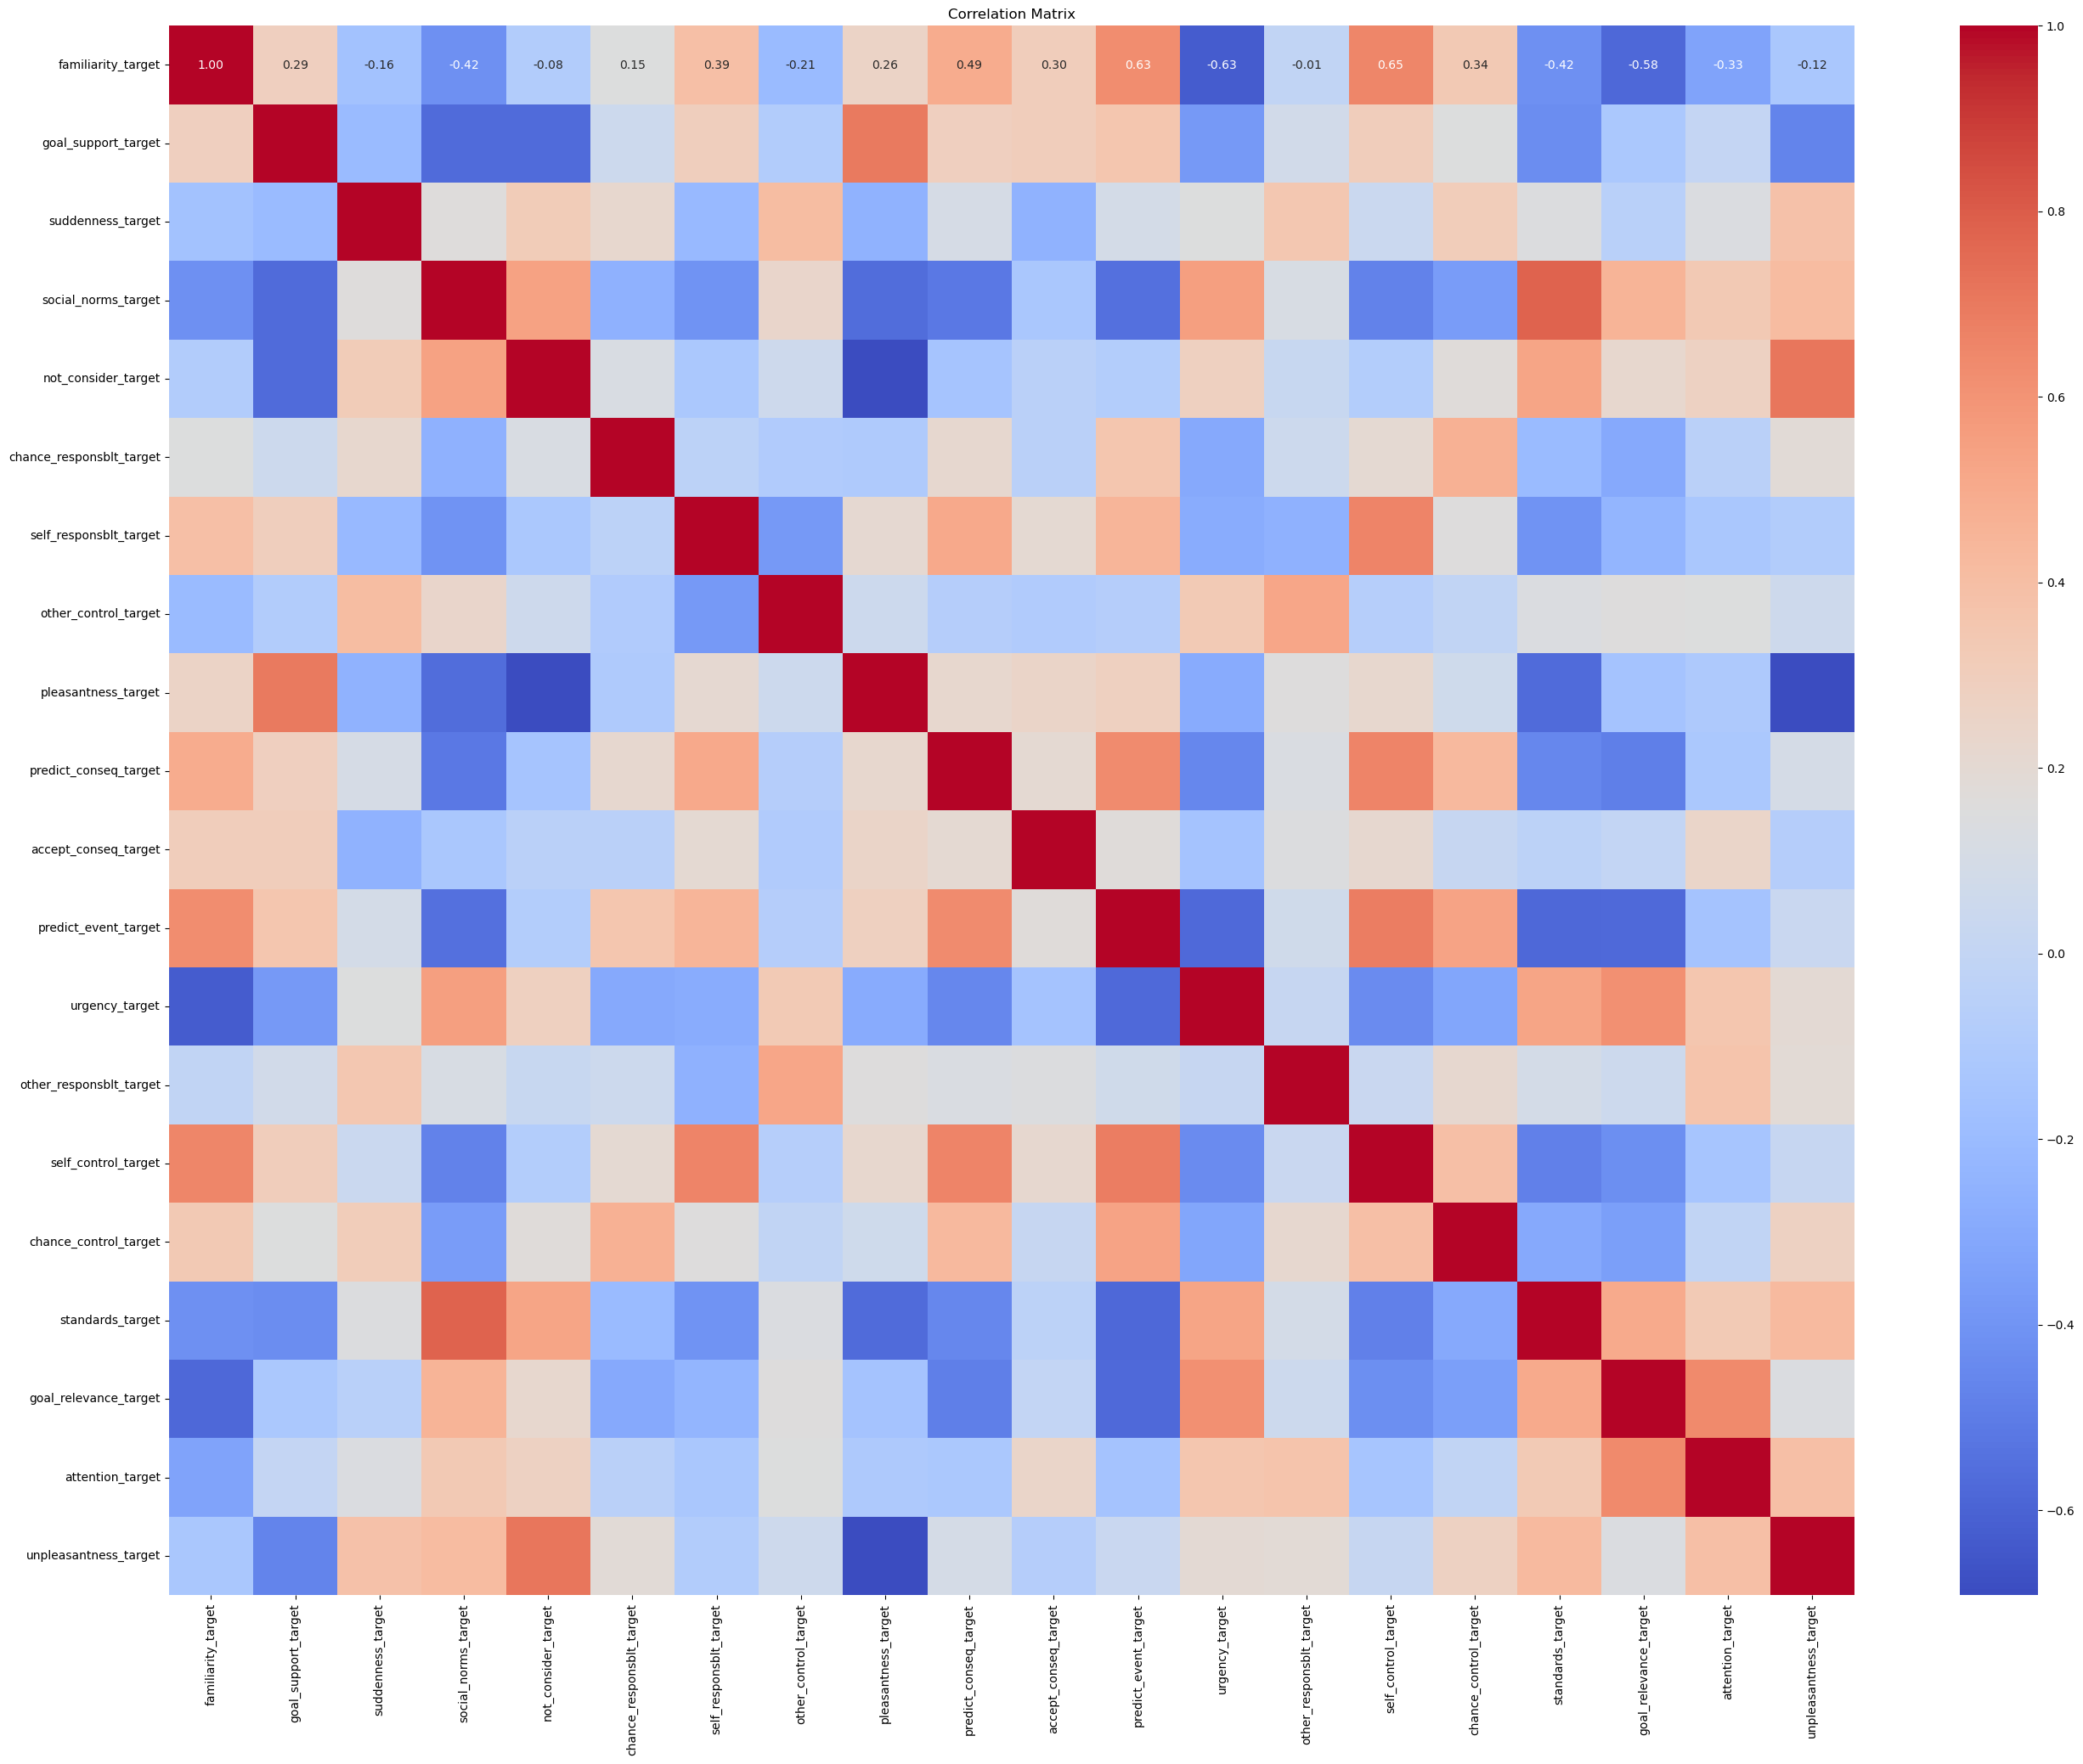

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [24]:
col_list = []
# col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
for col in aloe_df.columns:
    if '_observer' in col:
    # or '_level' in col:
        # or '_seeker' in col 
        col_list.append(col)

target_df = aloe_df[col_list]
corr_matrix = target_df.corr()
print(corr_matrix)

                            familiarity_observer  goal_support_observer  \
familiarity_observer                    1.000000               0.487299   
goal_support_observer                   0.487299               1.000000   
suddenness_observer                    -0.279640              -0.252280   
social_norms_observer                  -0.587858              -0.635539   
not_consider_observer                  -0.316607              -0.662321   
chance_responsblt_observer              0.320766               0.135510   
self_responsblt_observer                0.480650               0.490083   
other_control_observer                 -0.165555              -0.084576   
pleasantness_observer                   0.397006               0.840232   
predict_conseq_observer                 0.703574               0.499146   
accept_conseq_observer                  0.301130               0.454069   
predict_event_observer                  0.680513               0.486602   
urgency_observer         

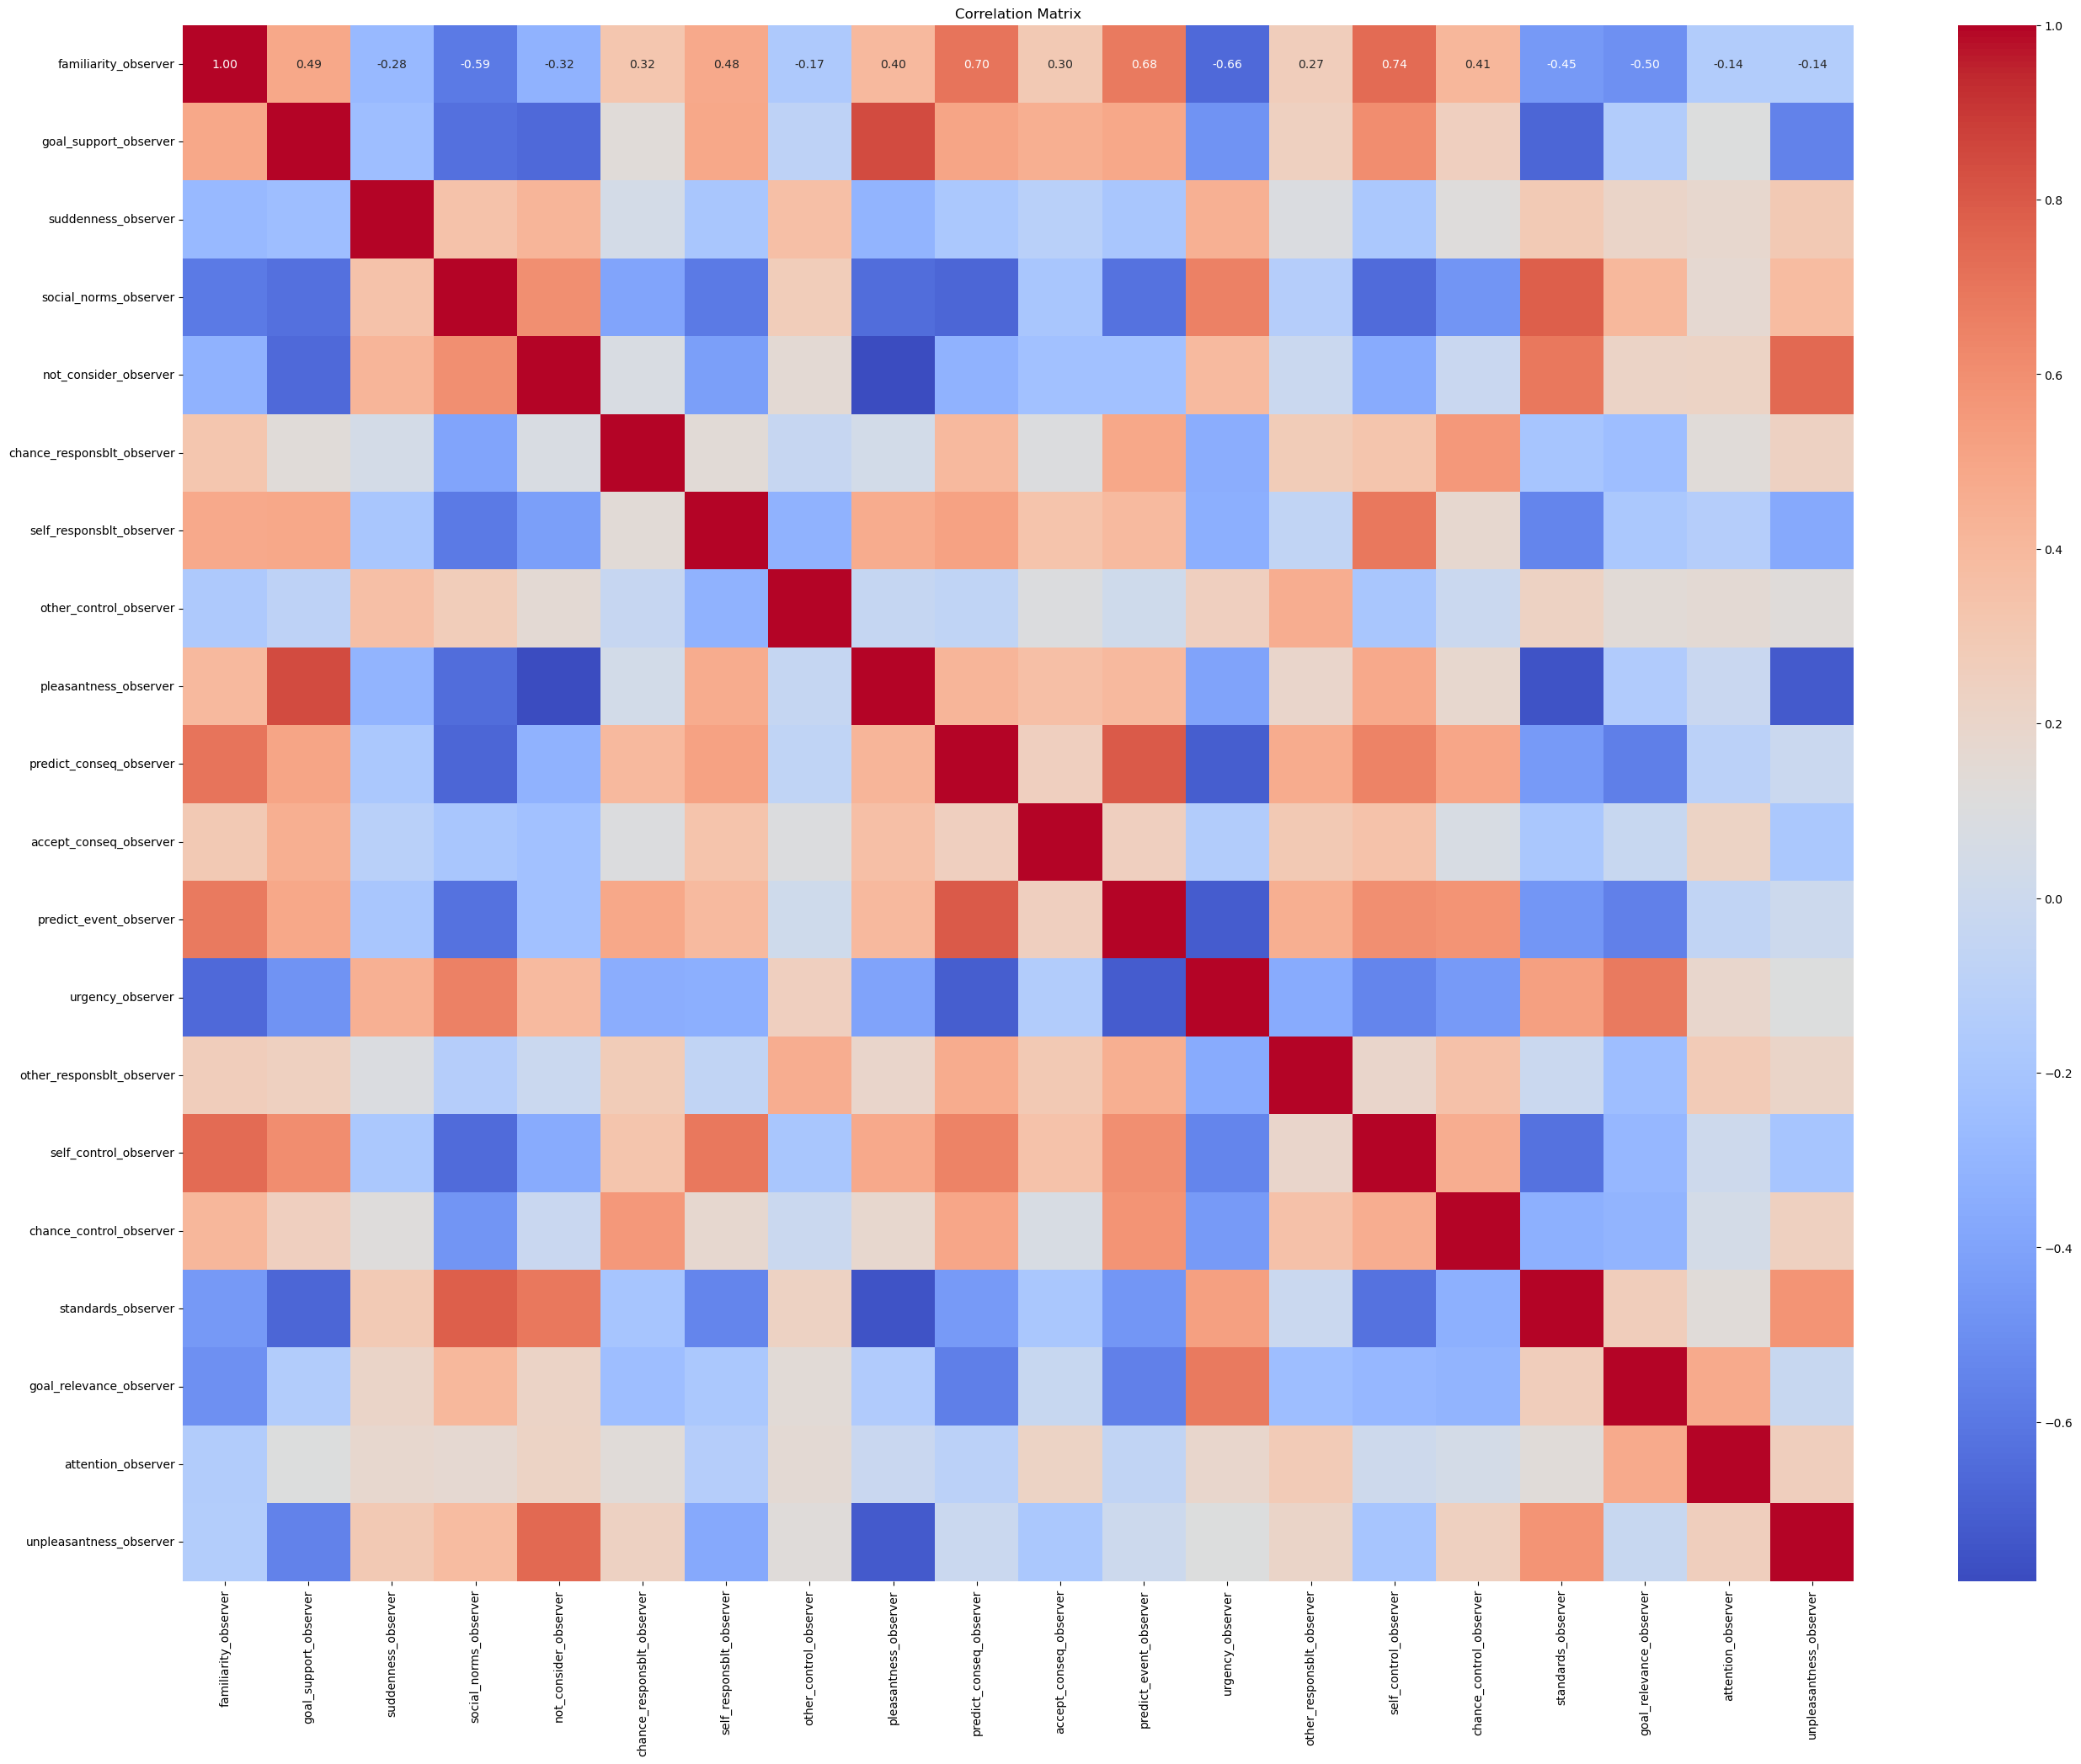

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [28]:
col_list = []
# col_list = [col if '_seeker' in col or '_response' in col for col in epi_df.columns]
for col in aloe_df.columns:
    if '_observer' in col or '_target' in col:
    # or '_level' in col:
        # or '_seeker' in col 
        col_list.append(col)

target_df = aloe_df[col_list]
corr_matrix = target_df.corr()
print(corr_matrix)

                            familiarity_target  goal_support_target  \
familiarity_target                    1.000000             0.287026   
goal_support_target                   0.287026             1.000000   
suddenness_target                    -0.158800            -0.206503   
social_norms_target                  -0.419665            -0.570086   
not_consider_target                  -0.083996            -0.567192   
chance_responsblt_target              0.151659             0.049213   
self_responsblt_target                0.394289             0.295152   
other_control_target                 -0.205078            -0.084562   
pleasantness_target                   0.255245             0.699817   
predict_conseq_target                 0.493192             0.291364   
accept_conseq_target                  0.300098             0.300921   
predict_event_target                  0.627541             0.358780   
urgency_target                       -0.627047            -0.378576   
other_

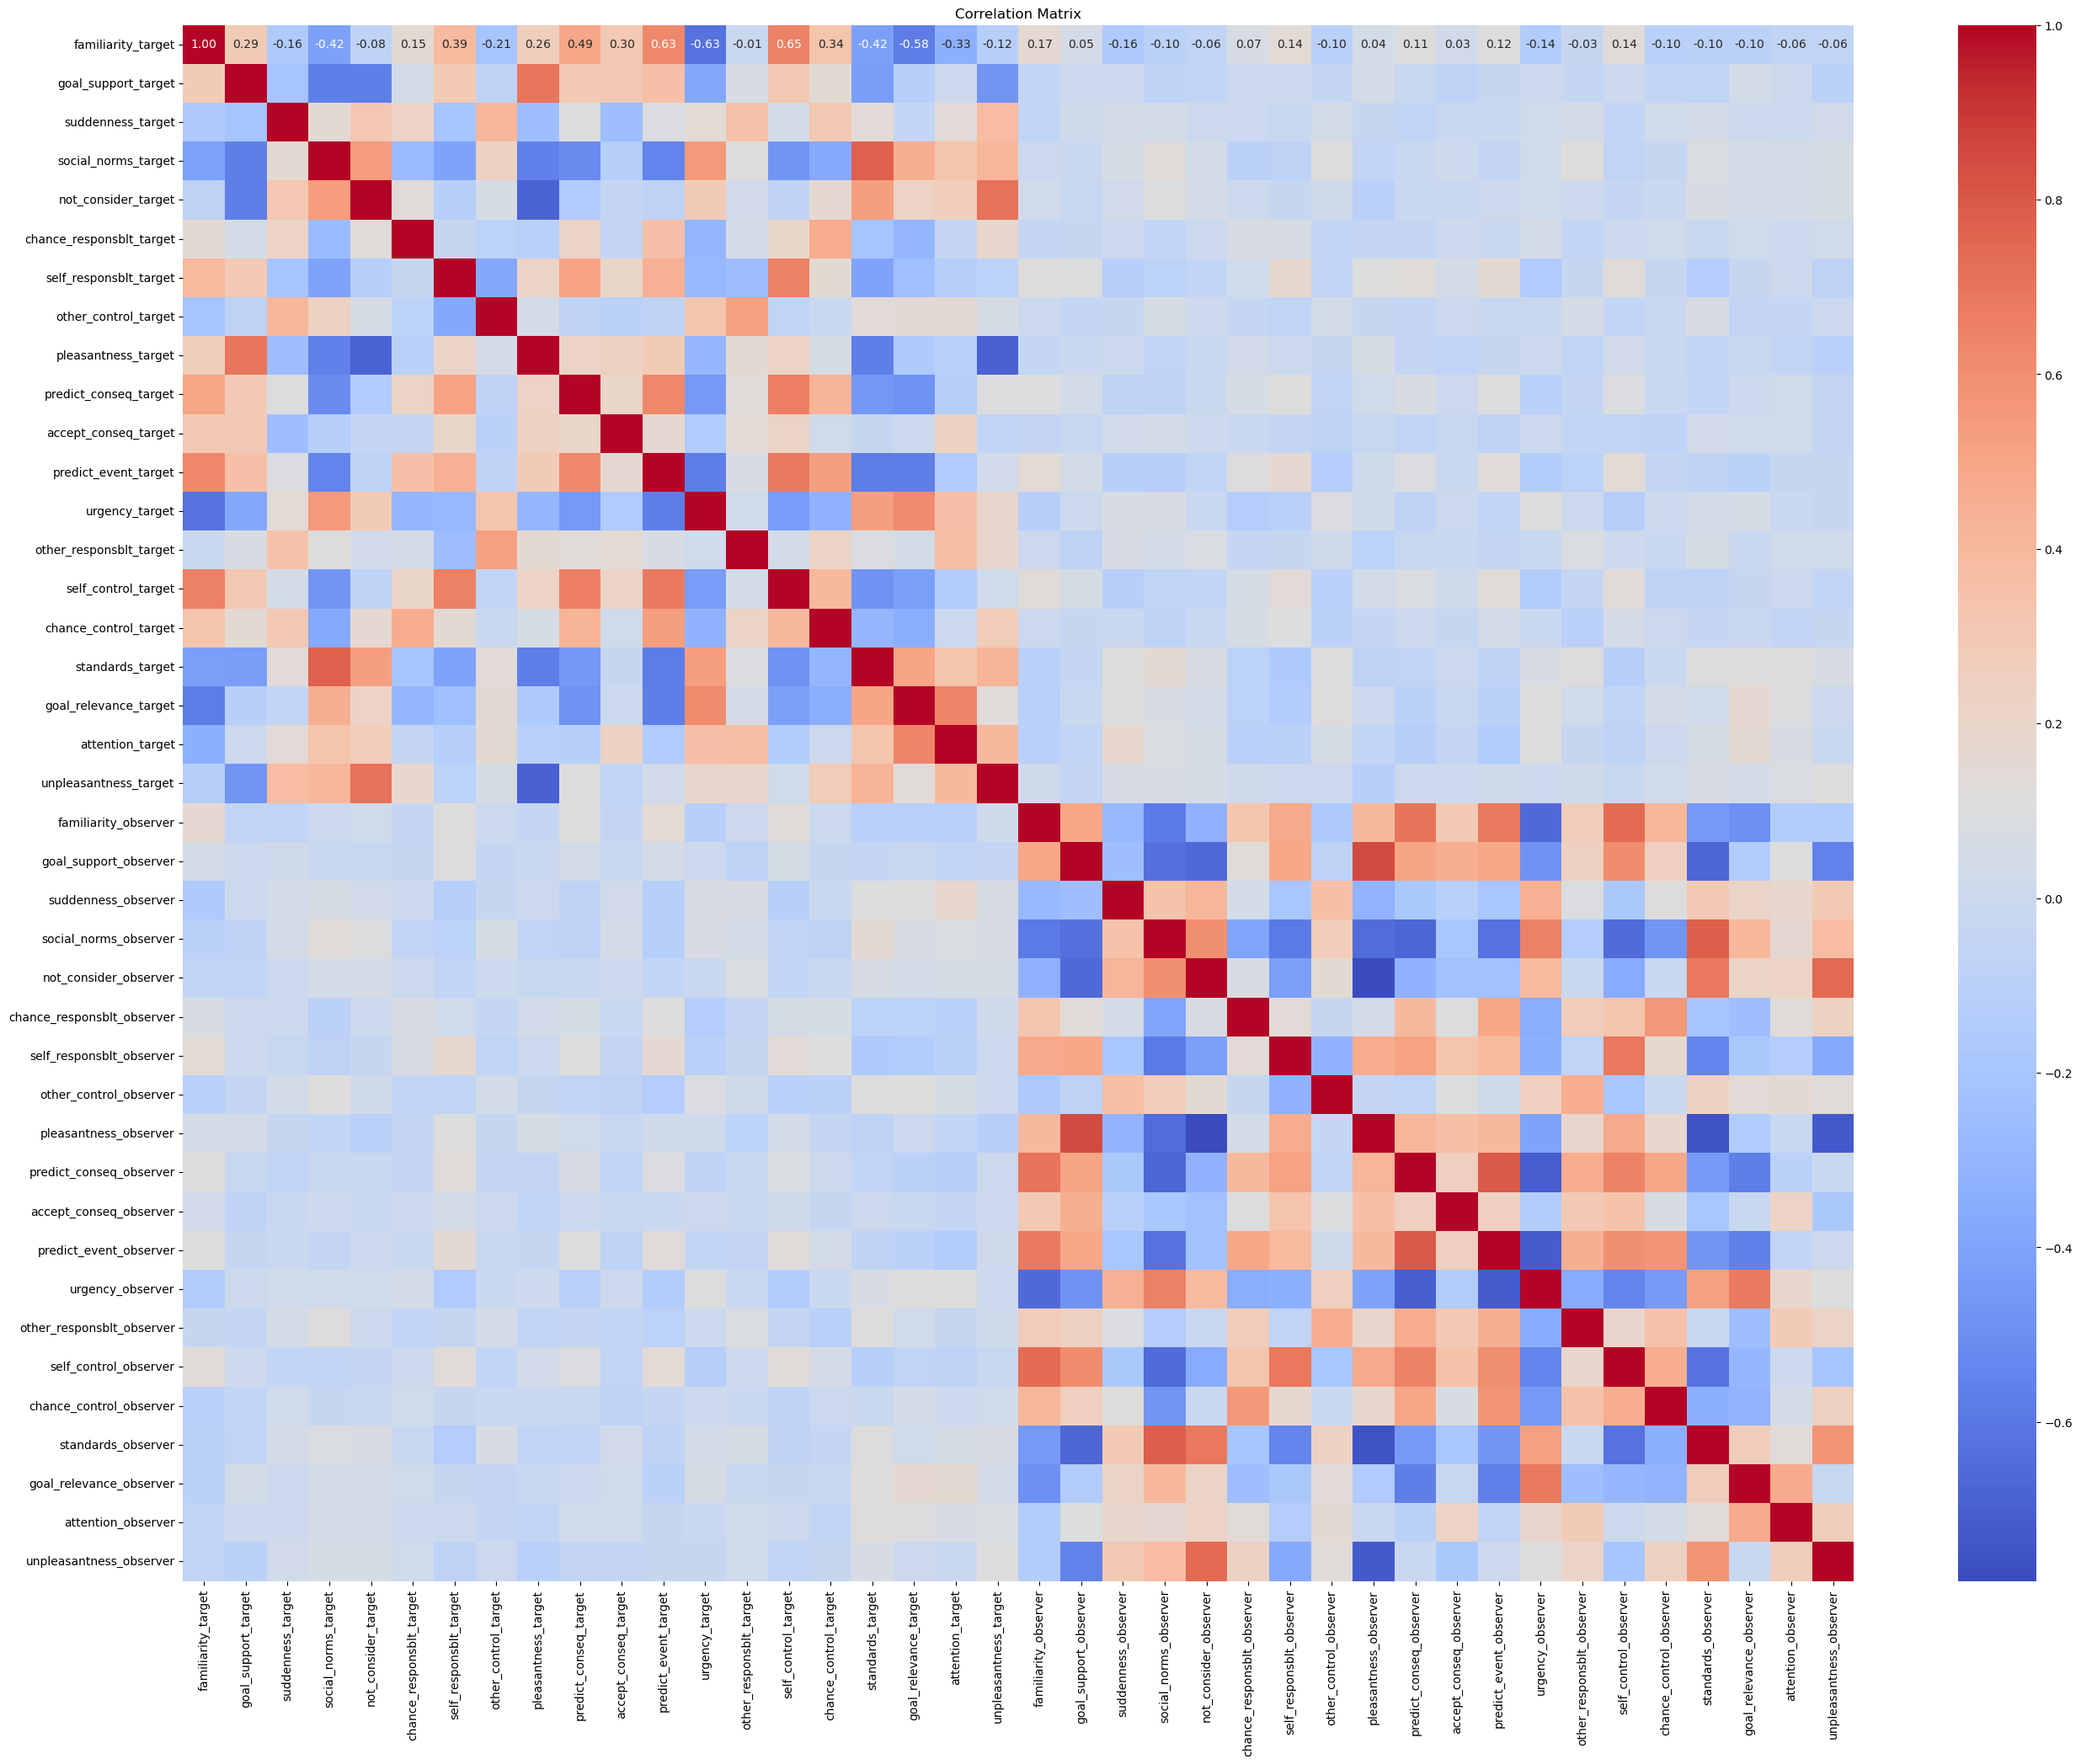

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [4]:
import pandas as pd

wassa_df = pd.read_csv('./dialogues/wassa_conv.csv')
wassa_df = wassa_df[wassa_df['sp1_idx'] != -1]
wassa_df.to_csv('./dialogues/wassa_conv_updated.csv')